# Install and import dependences

In [1]:
#!pip install --upgrade python-binance tensorflow

In [2]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix
from collections import Counter

# Load data

In [3]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [4]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [5]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='12h'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

# Model Functions

In [6]:
def model_1(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [7]:
def model_2(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [8]:
def model_3(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

# Other Functions

In [9]:
# Suppress the warning related to TensorFlow tracing
tf.autograph.set_verbosity(0)

def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols, print_info: bool = True):
    buy_list = []
    verify_buy_list = []
    total_loss = 0
    total_sold = 0
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2, loss = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)
            total_loss += loss

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.001 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None
            if sold_status:
                total_sold += 1
            

            if print_info:
                print('{:<2} '.format(count), 
                      '{:<8} -'.format(ticker), 
                      'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                      '/ Pred1: {:<10}'.format(round(float(pred1), 3)), 
                      '/ Pred2: {:<10}'.format(round(float(pred2), 3)), 
                      '/ TruePrice1: {:<10}'.format(round(float(true_price1), 3)), 
                      '/ TruePrice2: {:<10}'.format(round(float(true_price2), 3)), 
                      '|| ActStatus: {:<1}'.format(act_status), 
                      '/ MyActStatus: {:<1}'.format(my_act_status), 
                      '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                      '/ MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                      '/ GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                      '/ TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                      '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)
                
            if act_status and my_act_status:
                buy = ['{:<8}'.format(ticker), 
                       'LastPrice: {:<11}'.format(round(float(last_price), 5)), 
                       'MyGamble: {:<11}'.format(round(float(my_gamble), 5)), 
                       'TruePrice: {:<11}'.format(round(float(true_price1), 5)),
                       'GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                       'TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                       'SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''),
                       'CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0))]
                buy_list.append(buy)
                verify_buy_list.append([ticker, float(my_gamble), float(true_price1), float(last_price)])
                      

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        if len(buy_list) != 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', total_sold/len(buy_list), '\n')
        if len(buy_list) == 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', '\n') 
        
        for i in buy_list:
            print(i)
    
        index = my_confusion_matrix(true_status_list, pred_status_list)
        if len(index) > 0: 
            print('Wrong Buy_Act List:')
            for i in index:
                print(symbols[i], '\n')
    return verify_buy_list

In [10]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [11]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 + (pred1 * margin) <= last_value * 1.02:
            return pred1 + (pred1 * margin)
        else:
            return last_value * 1.02
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 <= last_value * 1.02:
            return pred1
        else: 
            return last_value * 1.02

    else:
        return pred1 - (pred1 * margin)

In [12]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

In [13]:
def get_avg_gamble(verify_list):
    tickers = []
    gambles = []
    true_prices = []
    last_prices = []
    
    for iteration in verify_list:
        iter_ticker = []
        iter_gamble = []
        iter_true_price = []
        iter_last_price = []
        for crypto in iteration:
            iter_ticker.append(crypto[0])
            iter_gamble.append(crypto[1])
            iter_true_price.append(crypto[2])
            iter_last_price.append(crypto[3])
        tickers.append(iter_ticker)
        gambles.append(iter_gamble)
        true_prices.append(iter_true_price)
        last_prices.append(iter_last_price)
        
    
    all_tickers = [ticker for sublist in tickers for ticker in sublist] # Flatten the list of lists into a single list
    ticker_counts = Counter(all_tickers) # Count the occurrences of each ticker symbol
    chosen_cryptos = []
    for ticker, count in ticker_counts.items():
        chosen_cryptos.append([ticker, count])    
    
    avg_gambles = {}
    for chosen in chosen_cryptos:
        if chosen[1] >= 6:
            ticker = chosen[0] 
            total_gamble = 0
            count = 0
            for iteration in verify_list:
                for crypto in iteration:
                    if crypto[0] == ticker:
                        count += 1
                        total_gamble += crypto[1]
                        true_price = crypto[2]
                        last_price = crypto[3]
            avg_gamble = total_gamble/count
            avg_gambles[ticker] = avg_gamble
            print(ticker, '/ Gamble:', avg_gamble, '/ TruePrice:', true_price, '/ SoldStatus:', avg_gamble <= (true_price*1.002), '/ GambleProft:', avg_gamble/last_price)
    return avg_gambles

# Predictions & Evaluate


Pred proft %: 1.0076908546331165
Gamble proft %: 1.0080277652901557
True proft %: 1.05314755517476

Look Back: 1 / Total Loss: 71968956.78544302 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.02995    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.90372  ', 'TruePrice: 109.59     ', 'GambleProft: 1.011', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.16431    ', 'TruePrice: 6.194      ', 'GambleProft: 1.01 ', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.1138    ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.45037   ', 'TruePrice: 38.75      ', 'GambleProft: 1.009', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectMod

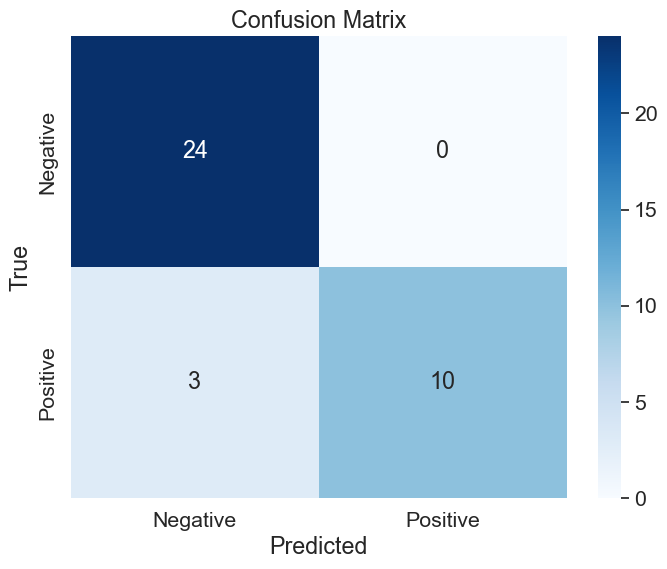

0:05:25.164526

Pred proft %: 1.0075563124109153
Gamble proft %: 1.007893450431853
True proft %: 1.0511532803558734

Look Back: 1 / Total Loss: 76117226.66751643 / Sold Portion: 1.0 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98261    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.41058  ', 'TruePrice: 109.59     ', 'GambleProft: 1.016', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.90212   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.49676   ', 'TruePrice: 38.75      ', 'GambleProft: 1.01 ', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.88227    ', 'TruePrice: 1.923      ', 'GambleProft: 1.006', 'TrueProft: 1.028', 'SoldStatus:

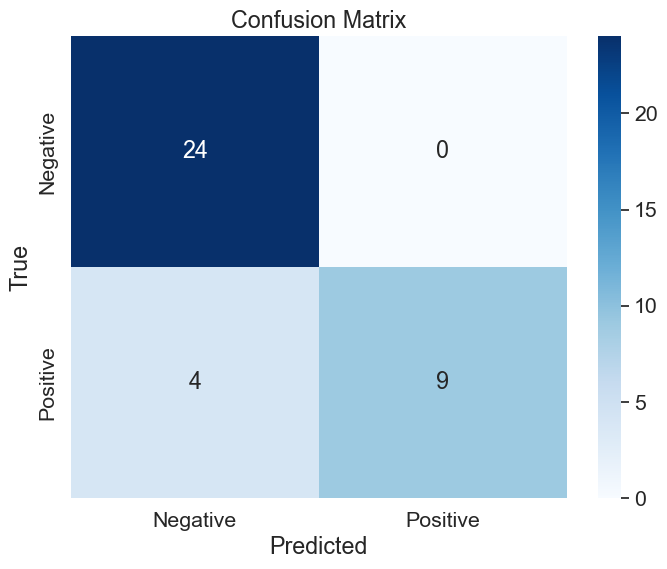

0:05:29.281344

Pred proft %: 1.0045499030424585
Gamble proft %: 1.0044462440757722
True proft %: 1.0258667957290142

Look Back: 1 / Total Loss: 88082630.3496785 / Sold Portion: 1.0 

['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.91999   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.42159   ', 'TruePrice: 38.75      ', 'GambleProft: 1.008', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.33477    ', 'TruePrice: 1.337      ', 'GambleProft: 1.013', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.52269    ', 'TruePrice: 8.72       ', 'GambleProft: 1.018', 'TrueProft: 1.042', 'SoldStatus:

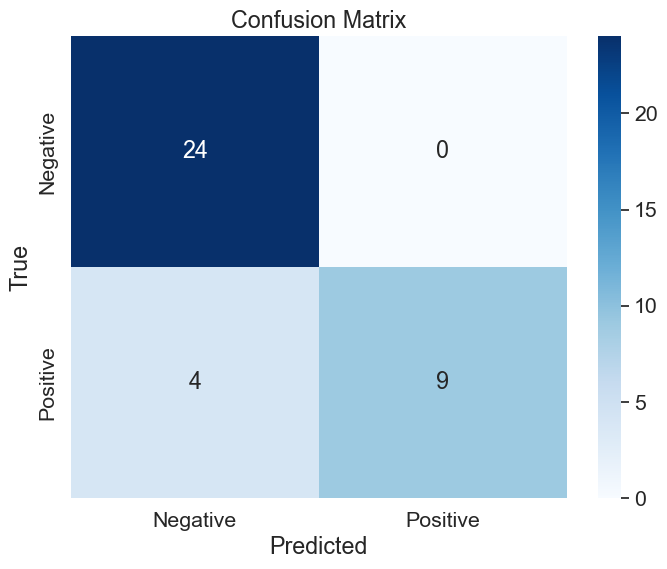

0:05:29.654025

Pred proft %: 1.0088721356927948
Gamble proft %: 1.00842401362035
True proft %: 1.0511393463224112

Look Back: 1 / Total Loss: 86842885.56808302 / Sold Portion: 0.7777777777777778 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98622    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.84188  ', 'TruePrice: 109.59     ', 'GambleProft: 1.01 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.10117   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.47923   ', 'TruePrice: 38.75      ', 'GambleProft: 1.01 ', 'TrueProft: 1.017'

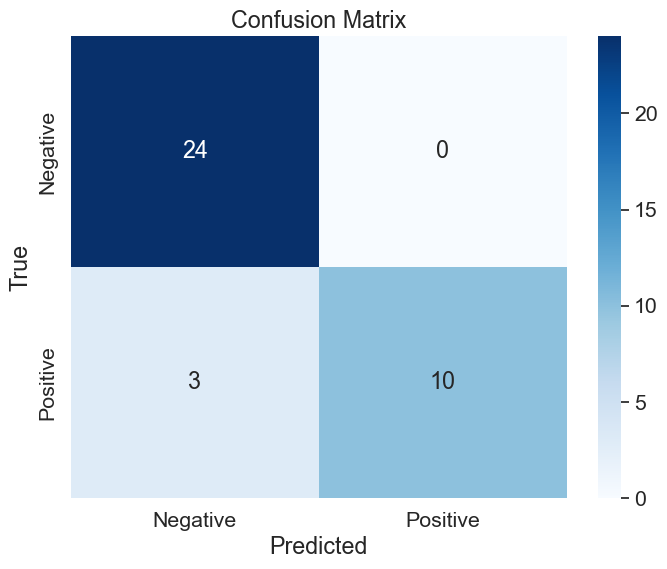

0:05:24.876844

Pred proft %: 1.0114410369818727
Gamble proft %: 1.010491152501883
True proft %: 1.0006509982684233

Look Back: 1 / Total Loss: 96505175.04610059 / Sold Portion: 0.9090909090909091 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03127    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2698.81118 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.011', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97635    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.02498   ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044

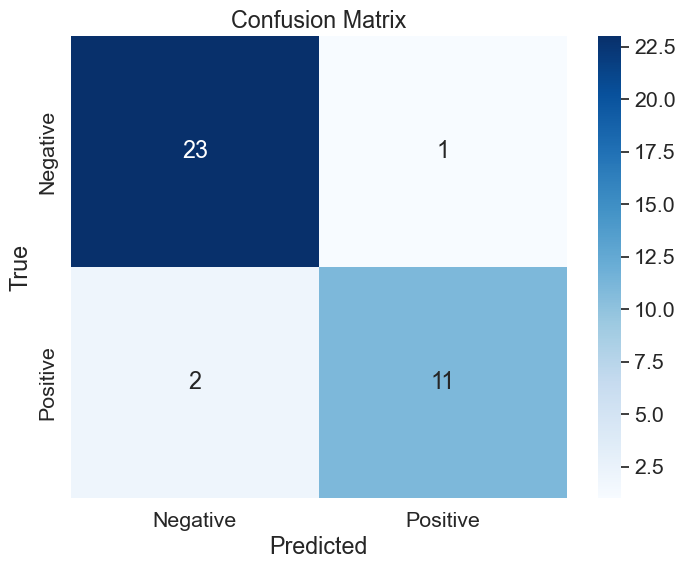

Wrong Buy_Act List:
BNBBRL 

0:05:28.741396

Pred proft %: 1.0031827569903158
Gamble proft %: 1.002857137628098
True proft %: 1.0503570283768215

Look Back: 1 / Total Loss: 49738485.23103231 / Sold Portion: 0.9 

['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.11394    ', 'TruePrice: 6.194      ', 'GambleProft: 1.002', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.96443   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.2957    ', 'TruePrice: 38.75      ', 'GambleProft: 1.005', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.88691    ', 'TruePrice: 1.923      ', 'GambleProft: 1.009', 'Tr

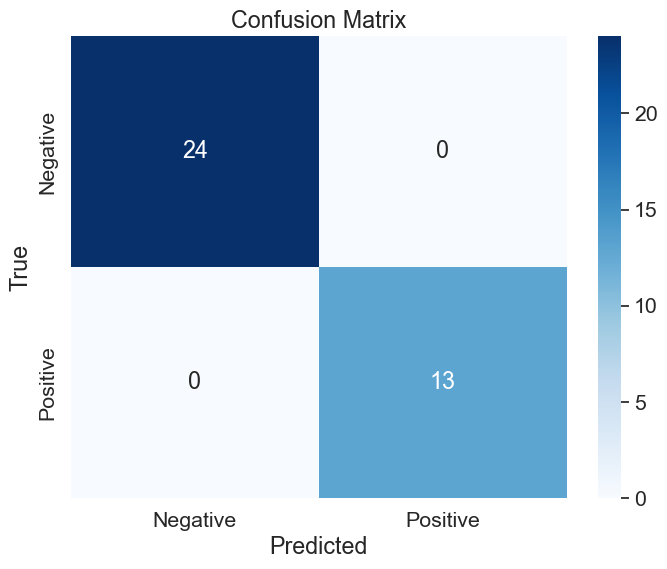

0:05:25.736836

Pred proft %: 1.0026380095398397
Gamble proft %: 1.001699080545887
True proft %: 1.0039504026755024

Look Back: 1 / Total Loss: 46219688.83895196 / Sold Portion: 0.8888888888888888 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.8368   ', 'TruePrice: 109.59     ', 'GambleProft: 1.02 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.17202    ', 'TruePrice: 6.194      ', 'GambleProft: 1.011', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.93321   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.66381   ', 'TruePrice: 38.75      ', 'GambleProft: 1.015', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.8834     ', 'TruePrice: 1.923      ', 'GambleProft: 1.007', 'TrueProft: 1.028

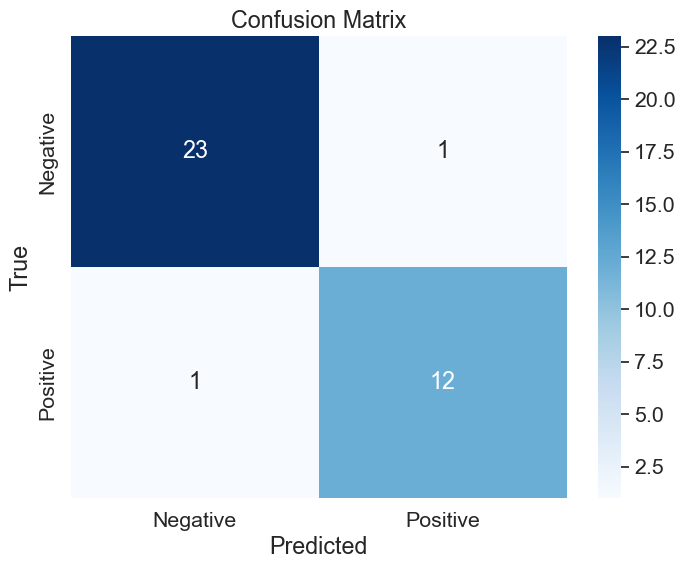

Wrong Buy_Act List:
BNBBRL 

0:05:38.179662

Pred proft %: 1.0059078314799903
Gamble proft %: 1.0053800830132582
True proft %: 1.0261869226105245

Look Back: 1 / Total Loss: 90813917.28691901 / Sold Portion: 0.7777777777777778 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97936    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.0146     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.008', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['SHIBBRL ', 'LastPrice: 0.00017    ', 'MyGamble: 0.00029    ', 'TruePrice: 0.00017    ', 'GambleProft: 1.69 ', 'TrueProft: 0.975', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.0527    ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.22725   ', 'TruePrice: 38.75      ', 'GamblePr

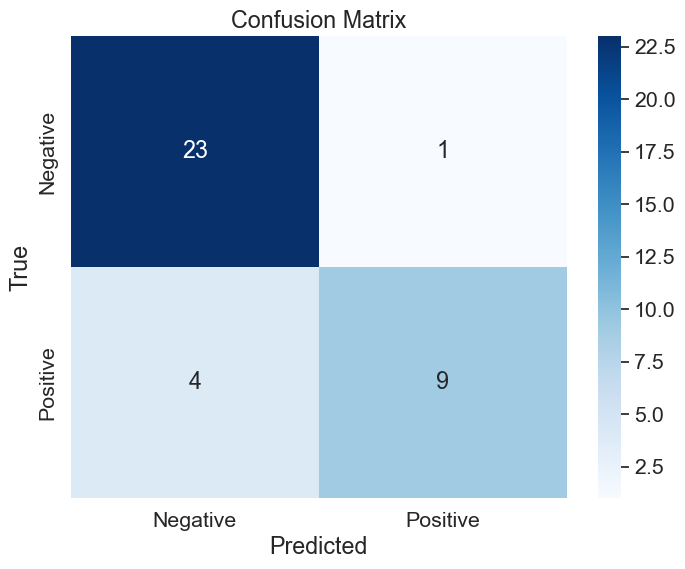

Wrong Buy_Act List:
SHIBBRL 

0:05:44.284470

Pred proft %: 1.0018838618139454
Gamble proft %: 1.0009430328201356
True proft %: 1.0006816007863355

Look Back: 1 / Total Loss: 65537534.988969356 / Sold Portion: 0.75 

['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.15304    ', 'TruePrice: 6.194      ', 'GambleProft: 1.008', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.90301   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.40504   ', 'TruePrice: 38.75      ', 'GambleProft: 1.008', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 2.94323    ', 'TruePrice: 1.923      ', 'GambleProft: 1.573', 'TrueProft: 1.028', 'SoldStatus: 0', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.5456    ', 'TruePrice: 19.78      ', 'GambleProft: 1.002'

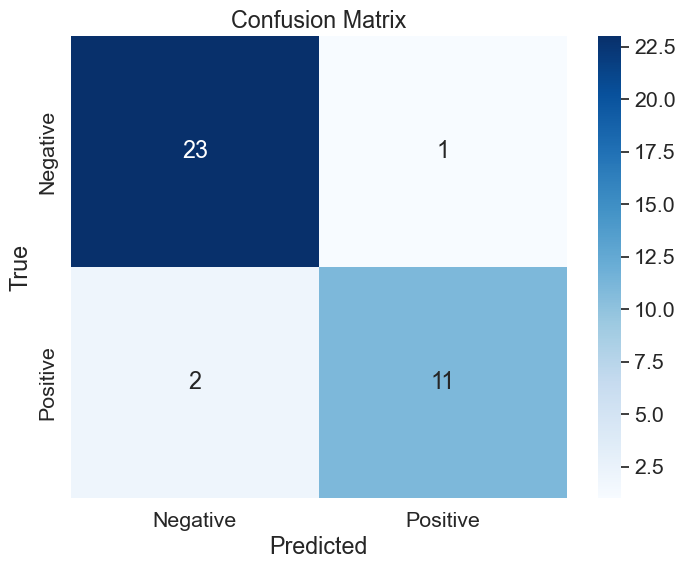

Wrong Buy_Act List:
BNBBRL 

0:05:35.187373

Pred proft %: 1.0061480493256967
Gamble proft %: 1.0067390785840444
True proft %: 1.0505405014045492

Look Back: 1 / Total Loss: 47899809.76980463 / Sold Portion: 0.875 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04475    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.37735  ', 'TruePrice: 109.59     ', 'GambleProft: 1.005', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.18087    ', 'TruePrice: 6.194      ', 'GambleProft: 1.013', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.93816   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 

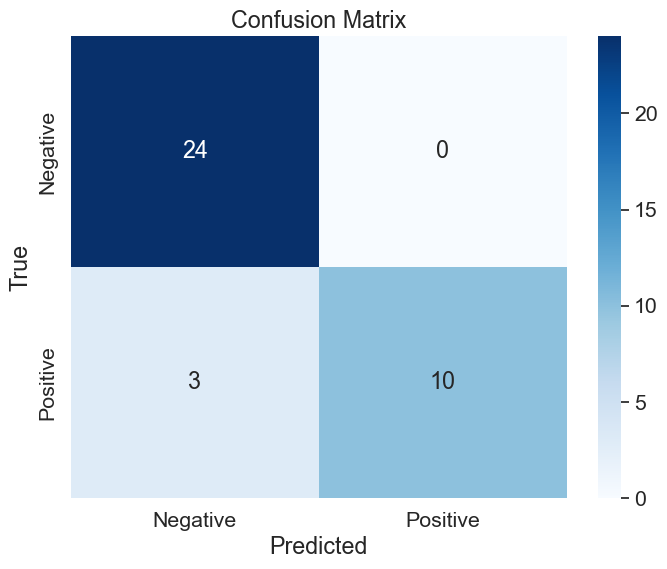

0:05:35.990132


In [116]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [117]:
get_avg_gamble(verify_list)

CAKEBRL / Gamble: 66.98535690307617 / TruePrice: 69.73 / SoldStatus: True / GambleProft: 1.0029249424026974
AXSBRL / Gamble: 38.47850036621094 / TruePrice: 38.75 / SoldStatus: True / GambleProft: 1.0099343928139353
GMTBRL / Gamble: 1.3372027479389732 / TruePrice: 1.337 / SoldStatus: True / GambleProft: 1.0153399756560162
GALBRL / Gamble: 8.462006996612548 / TruePrice: 8.72 / SoldStatus: True / GambleProft: 1.0109924727135662
APTBRL / Gamble: 39.84100808037652 / TruePrice: 40.17 / SoldStatus: True / GambleProft: 1.0043107658274897
BTTBRL / Gamble: 0.01474163824362556 / TruePrice: 0.01493 / SoldStatus: True / GambleProft: 1.0180689394769034
SANTOSBRL / Gamble: 19.739295189121794 / TruePrice: 19.78 / SoldStatus: True / GambleProft: 1.0117527006213118


{'CAKEBRL': 66.98535690307617,
 'AXSBRL': 38.47850036621094,
 'GMTBRL': 1.3372027479389732,
 'GALBRL': 8.462006996612548,
 'APTBRL': 39.84100808037652,
 'BTTBRL': 0.01474163824362556,
 'SANTOSBRL': 19.739295189121794}


Pred proft %: 1.0060002858725288
Gamble proft %: 1.005068664002273
True proft %: 1.0092429159617804

Look Back: 1 / Total Loss: 17783632.381319582 / Sold Portion: 1.0 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20363.56137', 'TruePrice: 20402.59   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.8352    ', 'TruePrice: 55.35      ', 'GambleProft: 1.02 ', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GambleProft: 1.02 ', 'TrueProft: 1.034', 'SoldStatus: 1', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 745.5      ', 'MyGamble: 746.5561   ', 'TruePrice: 746.9      ', 'GambleProft: 1.001', 'TrueProft: 1.002', 'SoldStatus: 1', 'CorrectM

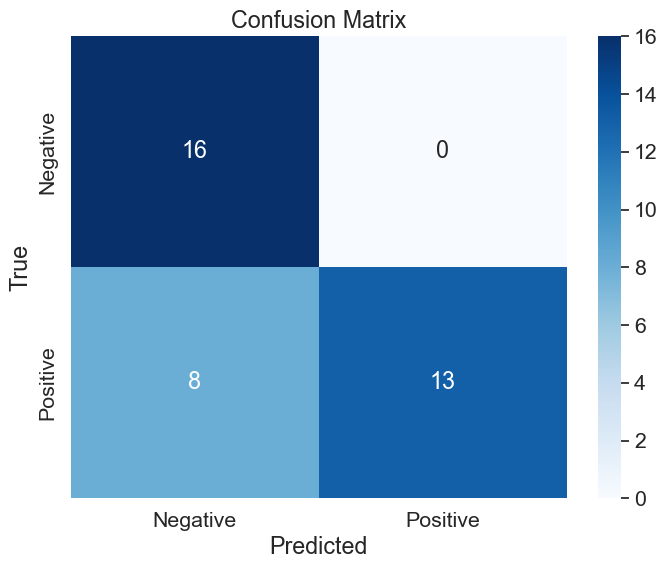

0:10:33.867987

Pred proft %: 1.0030749727447361
Gamble proft %: 1.0020736214612738
True proft %: 1.0072215910333207

Look Back: 1 / Total Loss: 2468377.0791750643 / Sold Portion: 0.8181818181818182 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359672.31141', 'TruePrice: 361599.0   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20347.7159 ', 'TruePrice: 20402.59   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2642.60938 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.008', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.37579   ', 'TruePrice: 55.35      ', 'GambleProft: 1.011', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.

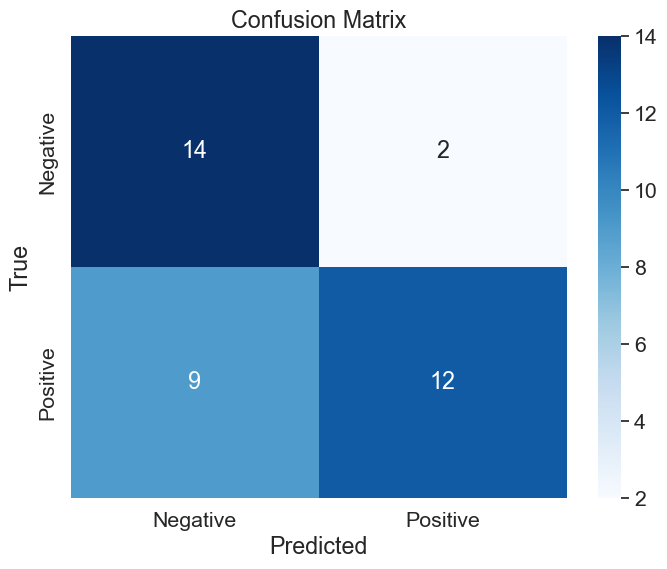

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

0:11:55.188932

Pred proft %: 1.0077682611701606
Gamble proft %: 1.0068506142477796
True proft %: 1.0099554584795807

Look Back: 1 / Total Loss: 35339758.026773356 / Sold Portion: 0.9 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20395.23474', 'TruePrice: 20402.59   ', 'GambleProft: 1.007', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.22066    ', 'TruePrice: 4.977      ', 'GambleProft: 1.05 ', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.15257    ', 'TruePrice: 3.627      ', 'GambleProft: 1.009', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 479.65978  ', 'TruePrice: 521.3      ', 'GambleProft: 1.01 ', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.88695    ', 'TruePrice: 0.9151     ', 'GambleProft:

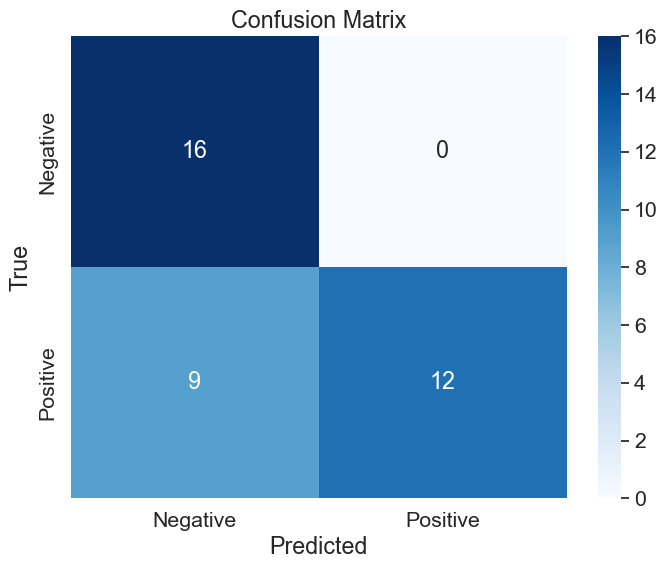

0:11:20.757824

Pred proft %: 1.0015183599558208
Gamble proft %: 1.0005213971327318
True proft %: 1.0073926330127045

Look Back: 1 / Total Loss: 2736315.9514652565 / Sold Portion: 0.8571428571428571 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20297.54737', 'TruePrice: 20402.59   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.88285    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.002', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.44808   ', 'TruePrice: 38.75      ', 'GambleProft: 1.009', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['AVAXBRL ', 'LastPrice: 232.4      ', 'MyGamble: 234.25441  ', 'TruePrice: 245.9      ', 'GambleProft: 1.008', 'TrueProft: 1.058', 'SoldStatus: 1', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.34334    ', 'TruePrice: 1.337      ', 'GambleProft: 1.02 ', 'TrueProft: 1.0

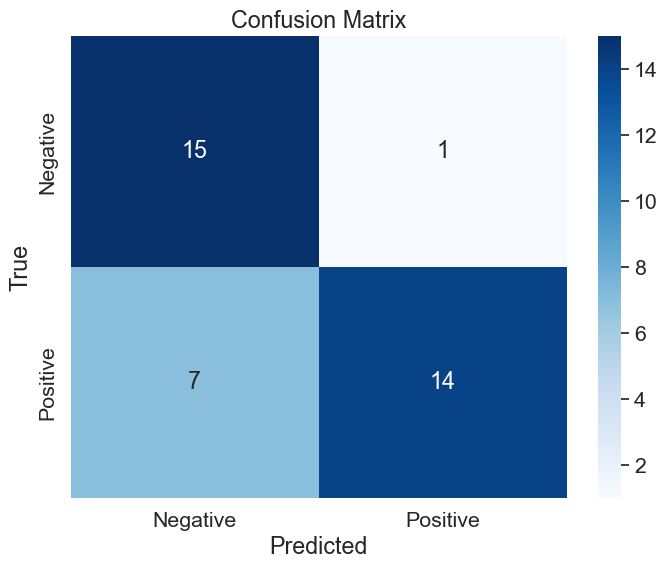

Wrong Buy_Act List:
USDTBRL 

0:10:37.434806

Pred proft %: 1.002127243984348
Gamble proft %: 1.001127045271776
True proft %: 1.0072233660107612

Look Back: 1 / Total Loss: 2586572.7855188707 / Sold Portion: 0.875 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359377.70006', 'TruePrice: 361599.0   ', 'GambleProft: 1.001', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2649.15044 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.01 ', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.18648    ', 'TruePrice: 3.627      ', 'GambleProft: 1.02 ', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.35651   ', 'TruePrice: 55.35      ', 'GambleProft: 1.011', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77245    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.008',

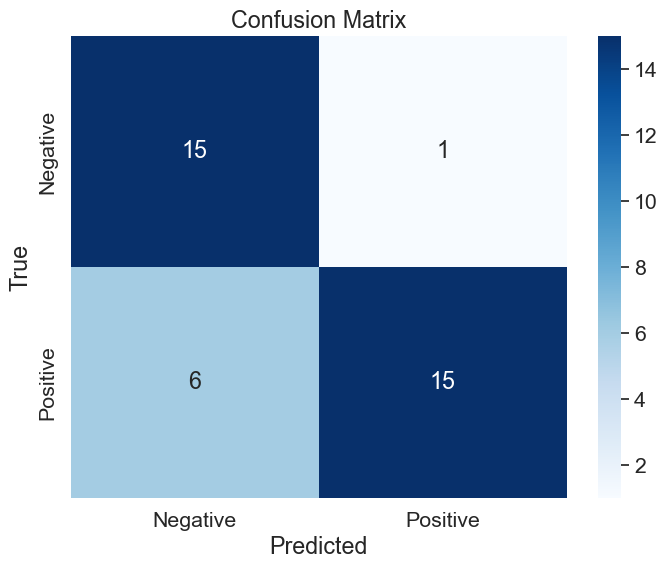

Wrong Buy_Act List:
BNBBRL 

0:10:30.941948

Pred proft %: 1.0023326509551886
Gamble proft %: 1.0013704755091426
True proft %: 1.0073360677282108

Look Back: 1 / Total Loss: 2483758.883952381 / Sold Portion: 0.9285714285714286 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359513.90747', 'TruePrice: 361599.0   ', 'GambleProft: 1.001', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2626.59587 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.002', 'TrueProft: 1.0  ', 'SoldStatus: 1', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14866    ', 'TruePrice: 3.627      ', 'GambleProft: 1.008', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 476.11205  ', 'TruePrice: 521.3      ', 'GambleProft: 1.002', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72206    ', 'TruePrice: 3.884      ', 'GambleP

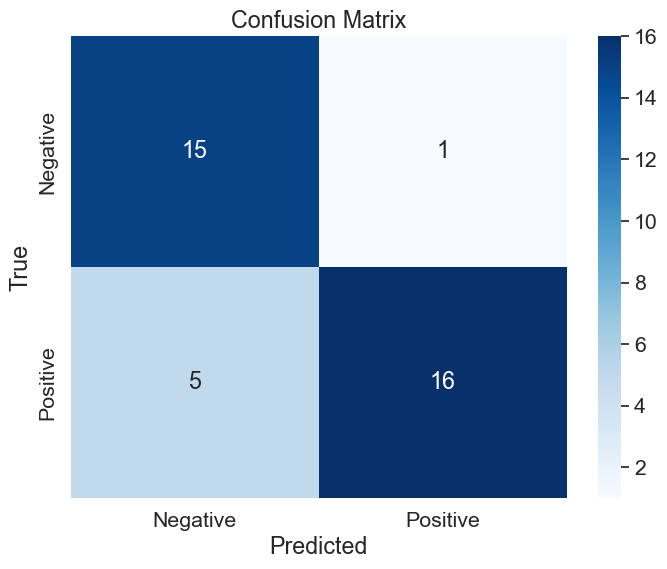

Wrong Buy_Act List:
BNBBRL 

0:09:31.189419

Pred proft %: 1.0060917173059774
Gamble proft %: 1.0051950590621388
True proft %: 1.008218007169125

Look Back: 1 / Total Loss: 7916894.715873215 / Sold Portion: 0.9090909090909091 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20363.14382', 'TruePrice: 20402.59   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2639.99359 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.007', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.8844     ', 'TruePrice: 0.9151     ', 'GambleProft: 1.004', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71799    ', 'TruePrice: 3.884      ', 'GambleProft: 1.003', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.78142    ', 'TruePrice: 0.8132     ', 'GamblePro

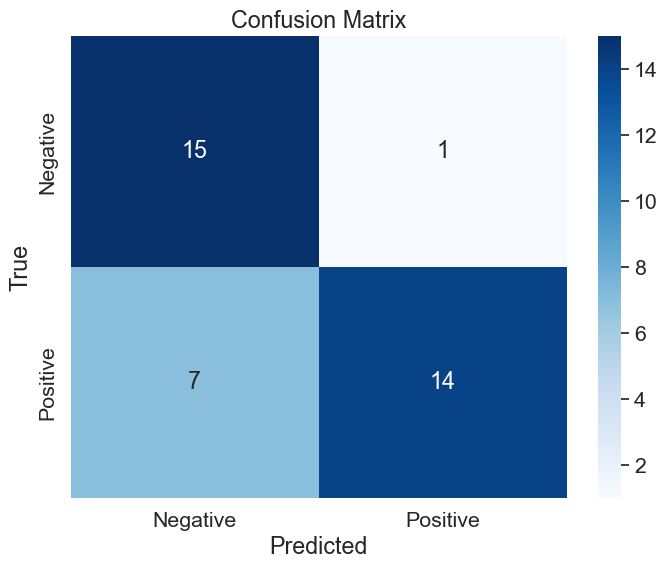

Wrong Buy_Act List:
BNBBRL 

0:08:43.280516

Pred proft %: 1.0141305231987756
Gamble proft %: 1.0131195060681433
True proft %: 1.0073306694949156

Look Back: 1 / Total Loss: 23602525.59409832 / Sold Portion: 0.875 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 363894.27272', 'TruePrice: 361599.0   ', 'GambleProft: 1.014', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.02718    ', 'TruePrice: 5.019      ', 'GambleProft: 1.001', 'TrueProft: 0.999', 'SoldStatus: 1', 'CorrectModel: 0']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20373.00309', 'TruePrice: 20402.59   ', 'GambleProft: 1.006', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2628.54802 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.002', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 482.73323  ', 'TruePrice: 521.3      ', 'GambleProft: 1.016',

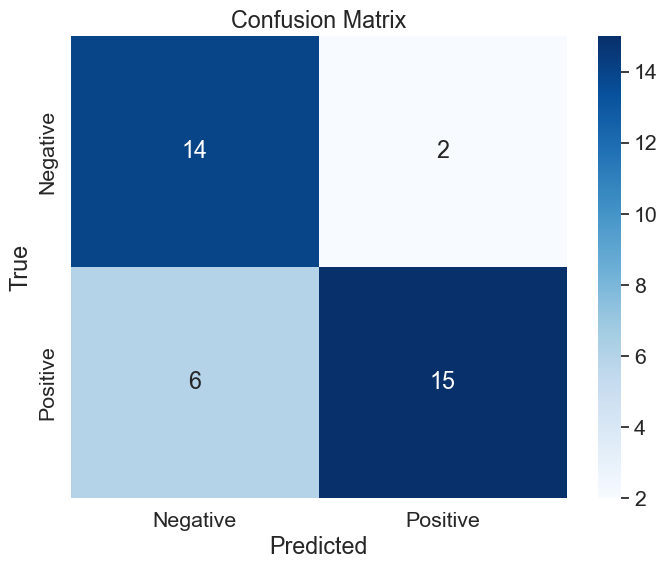

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

0:08:44.152510

Pred proft %: 1.0060029719382169
Gamble proft %: 1.0049985940714627
True proft %: 1.0072646464834625

Look Back: 1 / Total Loss: 3774586.4736030996 / Sold Portion: 0.8333333333333334 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 360794.21963', 'TruePrice: 361599.0   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97929    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71616    ', 'TruePrice: 3.884      ', 'GambleProft: 1.002', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77416    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.011', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01453    ', 'TruePrice: 0.01493    

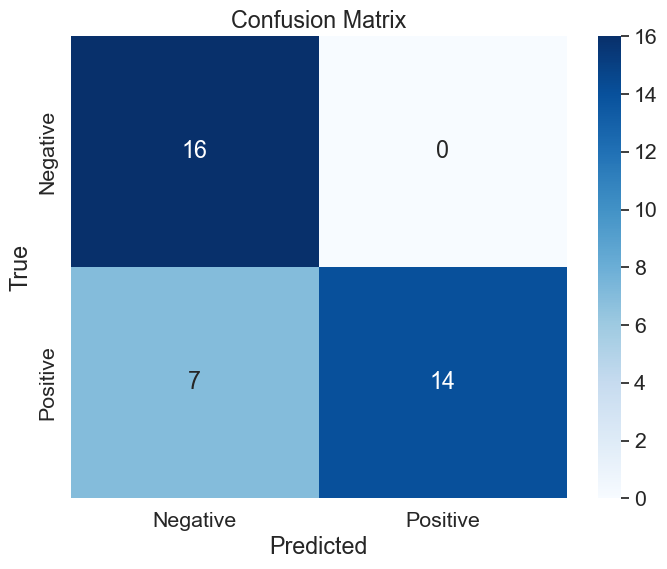

0:08:27.686013

Pred proft %: 1.0030400858350177
Gamble proft %: 1.0021091229453767
True proft %: 1.009755270126797

Look Back: 1 / Total Loss: 8549118.021372166 / Sold Portion: 0.8571428571428571 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03118    ', 'TruePrice: 5.019      ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20296.97568', 'TruePrice: 20402.59   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.30422  ', 'TruePrice: 521.3      ', 'GambleProft: 1.005', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.88422    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.003', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72551    ', 'TruePrice: 3.884      ', 'GambleProft: 1.005', 'TrueProft: 1.047

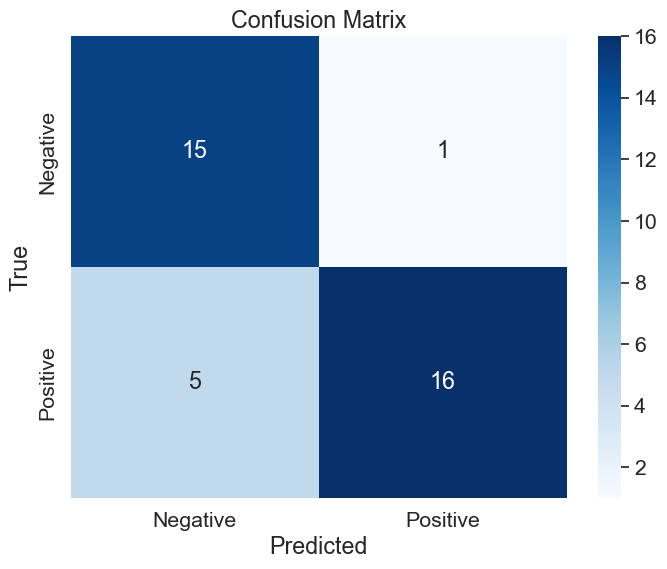

Wrong Buy_Act List:
USDTBRL 

0:08:57.973916


In [14]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 200, lb_list = [1], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [15]:
get_avg_gamble(verify_list)

ETHBRL / Gamble: 20348.168851004466 / TruePrice: 20402.59 / SoldStatus: True / GambleProft: 1.004551191845789
BTTBRL / Gamble: 0.014715884963516395 / TruePrice: 0.01493 / SoldStatus: True / GambleProft: 1.0162903980329003
SOLBRL / Gamble: 747.6833919067384 / TruePrice: 746.9 / SoldStatus: True / GambleProft: 1.0029287617796625
CAKEBRL / Gamble: 67.09460013253349 / TruePrice: 69.73 / SoldStatus: True / GambleProft: 1.004560564942858
AXSBRL / Gamble: 38.41930961608887 / TruePrice: 38.75 / SoldStatus: True / GambleProft: 1.0083808298186054
SANTOSBRL / Gamble: 19.66841615949358 / TruePrice: 19.78 / SoldStatus: True / GambleProft: 1.008119741644981
AVAXBRL / Gamble: 234.72888148498538 / TruePrice: 245.9 / SoldStatus: True / GambleProft: 1.0100210046686118
GMTBRL / Gamble: 1.3383918208312986 / TruePrice: 1.337 / SoldStatus: True / GambleProft: 1.016242840418602
GALBRL / Gamble: 8.415019353230795 / TruePrice: 8.72 / SoldStatus: True / GambleProft: 1.0053786562999756
APTBRL / Gamble: 39.890053

{'ETHBRL': 20348.168851004466,
 'BTTBRL': 0.014715884963516395,
 'SOLBRL': 747.6833919067384,
 'CAKEBRL': 67.09460013253349,
 'AXSBRL': 38.41930961608887,
 'SANTOSBRL': 19.66841615949358,
 'AVAXBRL': 234.72888148498538,
 'GMTBRL': 1.3383918208312986,
 'GALBRL': 8.415019353230795,
 'APTBRL': 39.89005334036691,
 'FTMBRL': 1.8942272575441994}


Pred proft %: 1.0050147643086895
Gamble proft %: 1.0040832553203793
True proft %: 1.0097298593578916

Look Back: 1 / Total Loss: 7607090.369472279 / Sold Portion: 0.9285714285714286 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.02822    ', 'TruePrice: 5.019      ', 'GambleProft: 1.001', 'TrueProft: 0.999', 'SoldStatus: 1', 'CorrectModel: 0']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20333.97965', 'TruePrice: 20402.59   ', 'GambleProft: 1.004', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 478.02848  ', 'TruePrice: 521.3      ', 'GambleProft: 1.006', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89039    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.01 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.78009    ', 'TruePrice: 3.884      ', 'GambleProft: 1.019', 'TrueProft: 1.047', 'SoldStatus

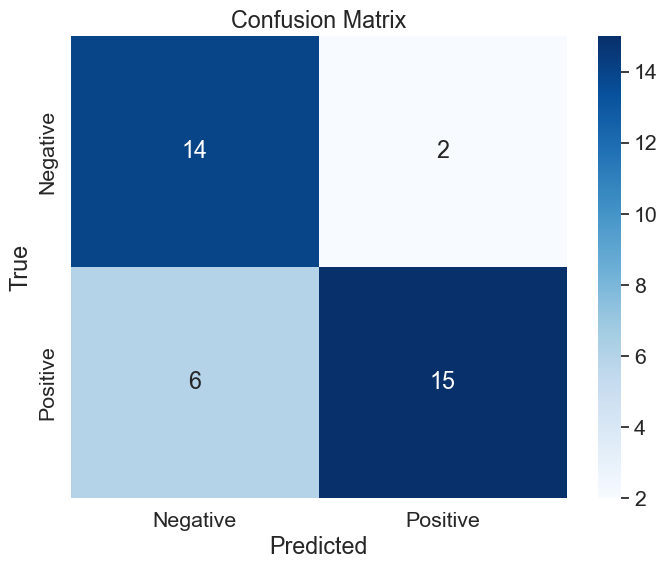

Wrong Buy_Act List:
USDTBRL 

C98BRL 

0:14:11.208413

Pred proft %: 0.9995088663663252
Gamble proft %: 1.000077554037067
True proft %: 1.0073354515702597

Look Back: 1 / Total Loss: 4000717.095158439 / Sold Portion: 0.6923076923076923 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03172    ', 'TruePrice: 5.019      ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2642.18061 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.008', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97931    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14927    ', 'TruePrice: 3.627      ', 'GambleProft: 1.008', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 481.28629  ', 'TruePrice: 521.3      ', 

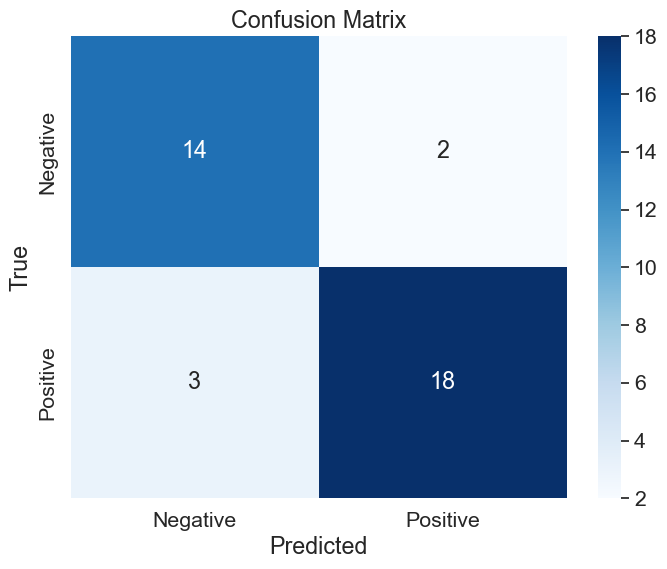

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

0:15:43.629256

Pred proft %: 1.0107093806749265
Gamble proft %: 1.0097011712581057
True proft %: 1.0074027846205273

Look Back: 1 / Total Loss: 10472152.500177735 / Sold Portion: 0.9166666666666666 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 362489.92847', 'TruePrice: 361599.0   ', 'GambleProft: 1.01 ', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.13722    ', 'TruePrice: 3.627      ', 'GambleProft: 1.004', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.75279    ', 'TruePrice: 3.884      ', 'GambleProft: 1.012', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77038    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.006', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    

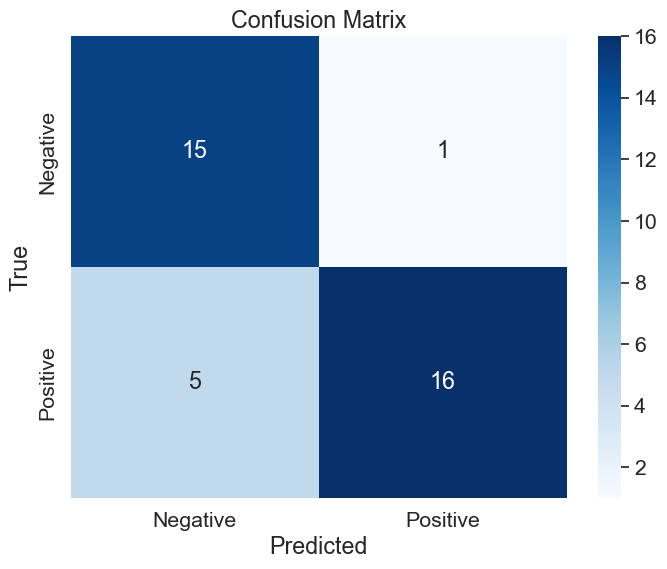

Wrong Buy_Act List:
USDTBRL 

0:14:08.515092

Pred proft %: 0.9978675702523002
Gamble proft %: 1.0000333144569094
True proft %: 1.0073496576621033

Look Back: 1 / Total Loss: 5829857.8159045465 / Sold Portion: 0.7777777777777778 

['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 479.44155  ', 'TruePrice: 521.3      ', 'GambleProft: 1.009', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.8874     ', 'TruePrice: 0.9151     ', 'GambleProft: 1.007', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72223    ', 'TruePrice: 3.884      ', 'GambleProft: 1.004', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01459    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.008', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 745.5      ', 'MyGamble: 753.02515  ', 'TruePrice: 746.9      ', 'Gamble

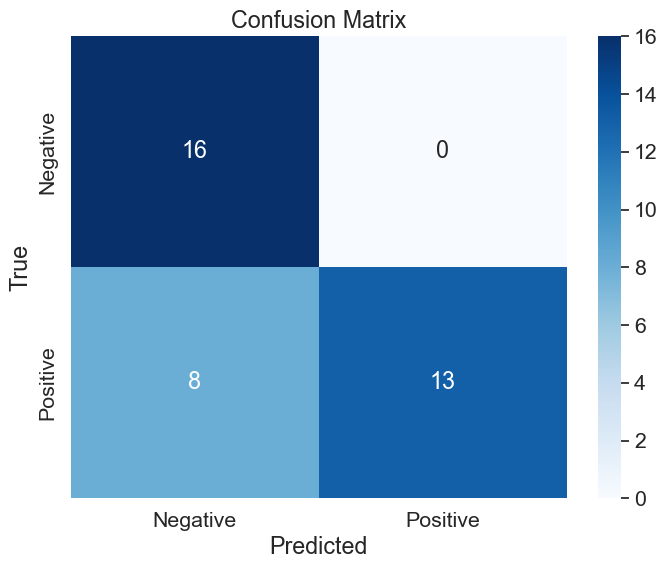

0:14:07.883583

Pred proft %: 1.0029782106354834
Gamble proft %: 1.0041976572553795
True proft %: 1.0701672881718458

Look Back: 1 / Total Loss: 6898737.065256638 / Sold Portion: 0.9 

['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.77372    ', 'TruePrice: 3.884      ', 'GambleProft: 1.018', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.95409   ', 'TruePrice: 55.35      ', 'GambleProft: 1.004', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.0146     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.009', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.96782   ', 'TruePrice: 69.73      ', 'GambleProft: 1.003', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.58567   ', 'TruePrice: 38.75      ', 'GambleProft: 1.013', 'TrueProft: 1.017', 'SoldStatus

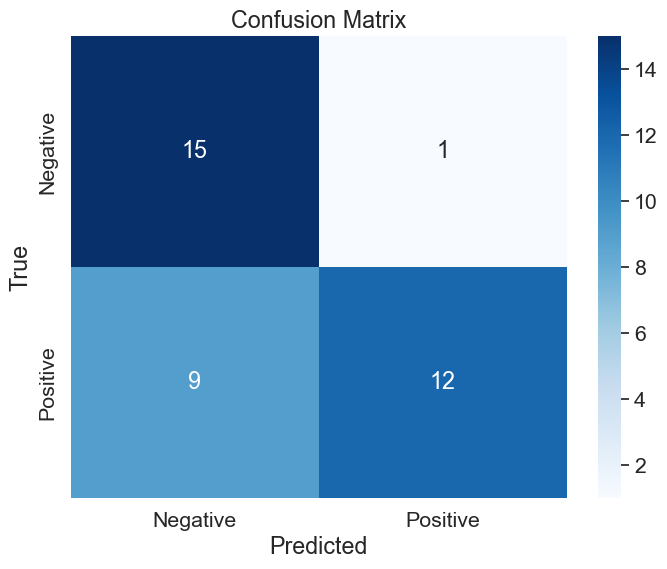

Wrong Buy_Act List:
USDTBRL 

0:14:06.032343

Pred proft %: 1.0009973385602966
Gamble proft %: 1.0000688241674796
True proft %: 1.0072525516983402

Look Back: 1 / Total Loss: 2883367.590320067 / Sold Portion: 1.0 

['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.88582    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.005', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72192    ', 'TruePrice: 3.884      ', 'GambleProft: 1.004', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.10393   ', 'TruePrice: 55.35      ', 'GambleProft: 1.006', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77277    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.009', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.94975   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', '

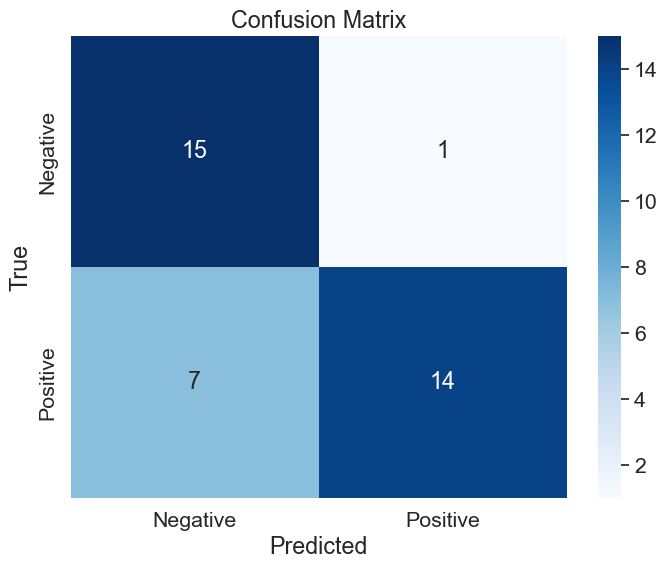

Wrong Buy_Act List:
USDTBRL 

0:14:18.468821

Pred proft %: 1.0053959801732757
Gamble proft %: 1.004393832485423
True proft %: 1.0073085236948547

Look Back: 1 / Total Loss: 3317857.96212392 / Sold Portion: 0.8333333333333334 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 360588.11344', 'TruePrice: 361599.0   ', 'GambleProft: 1.004', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.16064    ', 'TruePrice: 3.627      ', 'GambleProft: 1.012', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 476.87044  ', 'TruePrice: 521.3      ', 'GambleProft: 1.004', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71973    ', 'TruePrice: 3.884      ', 'GambleProft: 1.003', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.10645   ', 'TruePrice: 55.35      ', 'GamblePr

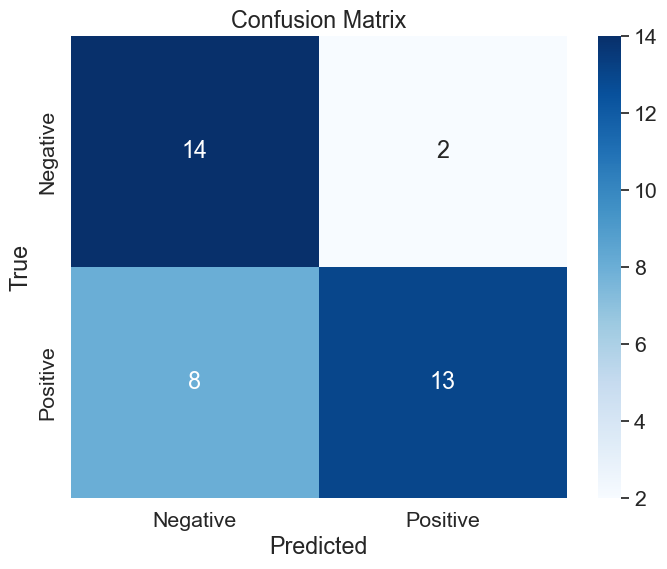

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

0:14:11.353181

Pred proft %: 1.0026887753869829
Gamble proft %: 1.0016928318906695
True proft %: 1.007343068049683

Look Back: 1 / Total Loss: 2460244.1240688288 / Sold Portion: 0.9 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359639.90634', 'TruePrice: 361599.0   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14803    ', 'TruePrice: 3.627      ', 'GambleProft: 1.008', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 478.20548  ', 'TruePrice: 521.3      ', 'GambleProft: 1.007', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.73249    ', 'TruePrice: 3.884      ', 'GambleProft: 1.007', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77386    ', 'TruePrice: 0.8132     ', 'GambleProft:

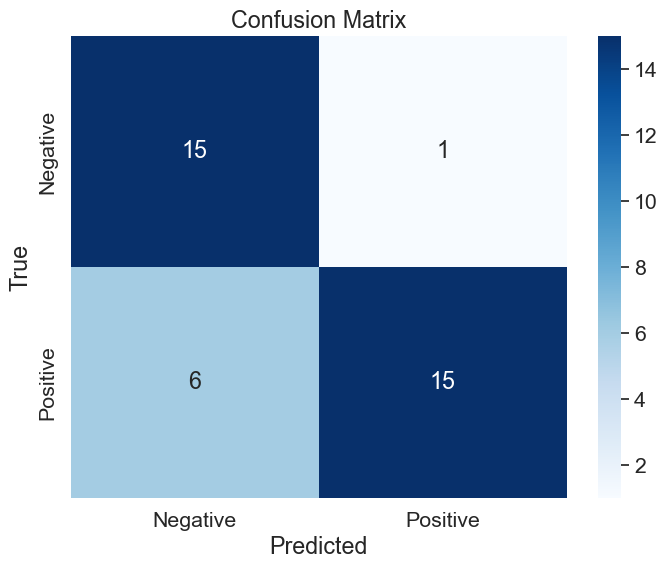

Wrong Buy_Act List:
BNBBRL 

0:14:07.527378

Pred proft %: 0.9989090221755776
Gamble proft %: 1.000027683931944
True proft %: 1.0073550699242013

Look Back: 1 / Total Loss: 4564310.761933052 / Sold Portion: 0.8181818181818182 

['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.64205  ', 'TruePrice: 521.3      ', 'GambleProft: 1.006', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89338    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.014', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.96889   ', 'TruePrice: 55.35      ', 'GambleProft: 1.004', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.76964    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.005', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 745.5      ', 'MyGamble: 752.50535  ', 'TruePrice: 746.9      ', 'GamblePro

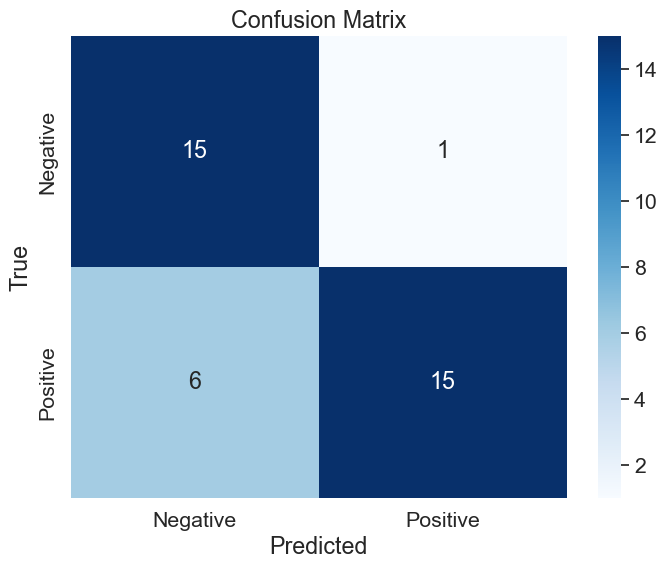

Wrong Buy_Act List:
USDTBRL 

0:14:08.044892

Pred proft %: 0.9994104963138803
Gamble proft %: 1.0002352429885588
True proft %: 1.0096671436671008

Look Back: 1 / Total Loss: 7039035.125382601 / Sold Portion: 1.0 

['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 476.49509  ', 'TruePrice: 521.3      ', 'GambleProft: 1.003', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.86177   ', 'TruePrice: 55.35      ', 'GambleProft: 1.002', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.76899    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.004', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.48986   ', 'TruePrice: 38.75      ', 'GambleProft: 1.01 ', '

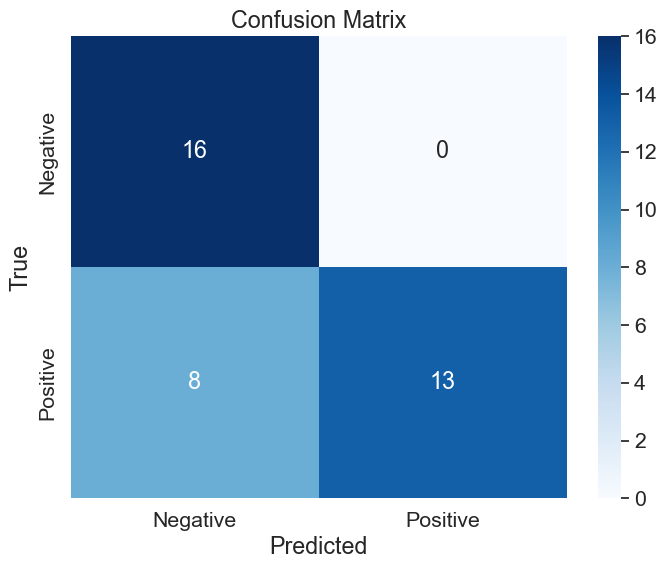

0:14:10.585787


In [16]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 300, lb_list = [1], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [17]:
get_avg_gamble(verify_list)

LTCBRL / Gamble: 478.28134008789056 / TruePrice: 521.3 / SoldStatus: True / GambleProft: 1.0069080843955591
ADABRL / Gamble: 3.743281398500715 / TruePrice: 3.884 / SoldStatus: True / GambleProft: 1.0095149402644863
CAKEBRL / Gamble: 67.08522203233507 / TruePrice: 69.73 / SoldStatus: True / GambleProft: 1.004420153201603
AXSBRL / Gamble: 38.45148522513254 / TruePrice: 38.75 / SoldStatus: True / GambleProft: 1.00922533399298
FTMBRL / Gamble: 1.882991373538971 / TruePrice: 1.923 / SoldStatus: True / GambleProft: 1.0064090719075205
SANTOSBRL / Gamble: 19.750832893880208 / TruePrice: 19.78 / SoldStatus: True / GambleProft: 1.012344074519744
GALBRL / Gamble: 8.41643796648298 / TruePrice: 8.72 / SoldStatus: True / GambleProft: 1.0055481441437253
CHZBRL / Gamble: 0.7720657989084719 / TruePrice: 0.8132 / SoldStatus: True / GambleProft: 1.007787232617768
GMTBRL / Gamble: 1.3400047076177597 / TruePrice: 1.337 / SoldStatus: False / GambleProft: 1.0174675076824296


{'LTCBRL': 478.28134008789056,
 'ADABRL': 3.743281398500715,
 'CAKEBRL': 67.08522203233507,
 'AXSBRL': 38.45148522513254,
 'FTMBRL': 1.882991373538971,
 'SANTOSBRL': 19.750832893880208,
 'GALBRL': 8.41643796648298,
 'CHZBRL': 0.7720657989084719,
 'GMTBRL': 1.3400047076177597}


Pred proft %: 1.0025875166249405
Gamble proft %: 1.0032531648704095
True proft %: 1.0793517497076368

Look Back: 1 / Total Loss: 11425321.117727883 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.0276     ', 'TruePrice: 5.019      ', 'GambleProft: 1.001', 'TrueProft: 0.999', 'SoldStatus: 1', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.15288    ', 'TruePrice: 3.627      ', 'GambleProft: 1.009', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 476.25682  ', 'TruePrice: 521.3      ', 'GambleProft: 1.003', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.8835     ', 'TruePrice: 0.9151     ', 'GambleProft: 1.002', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71438    ', 'TruePrice: 3.884      ', 'GambleProft: 1.002', 'TrueProft: 1.047', 'SoldStatus: 1', 'Correct

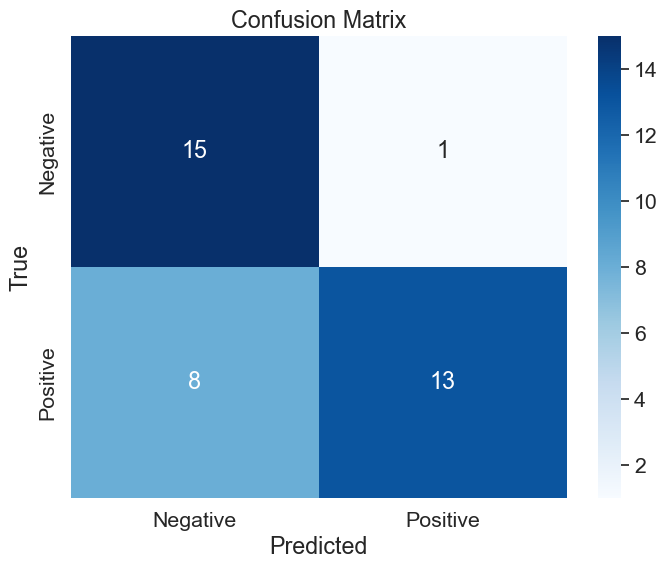

Wrong Buy_Act List:
USDTBRL 

0:18:22.143777

Pred proft %: 1.0045534966741252
Gamble proft %: 1.0035522293961043
True proft %: 1.0073075246306389

Look Back: 1 / Total Loss: 2846480.681920117 / Sold Portion: 0.8571428571428571 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 360271.368 ', 'TruePrice: 361599.0   ', 'GambleProft: 1.004', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2633.64692 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.004', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 478.81107  ', 'TruePrice: 521.3      ', 'GambleProft: 1.008', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.88989    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.01 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.84171   ', 'TruePrice: 55.35      ', 'GambleP

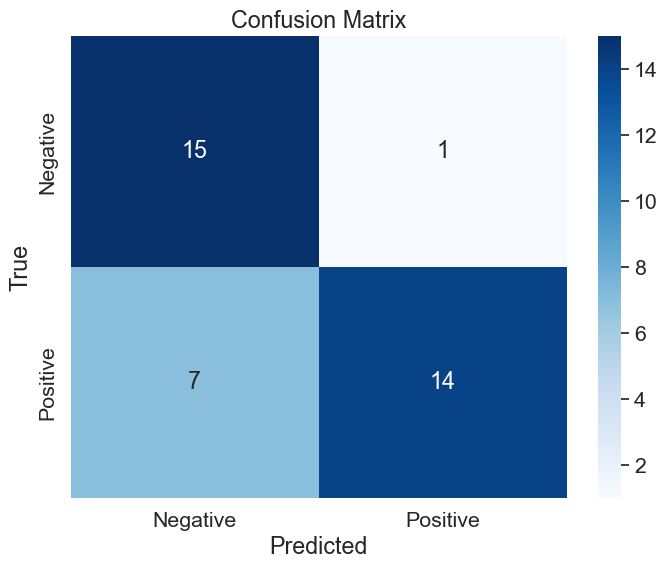

Wrong Buy_Act List:
BNBBRL 

0:18:21.080288

Pred proft %: 1.0088056185770105
Gamble proft %: 1.0078625706641655
True proft %: 1.008695494798911

Look Back: 1 / Total Loss: 6968203.441005448 / Sold Portion: 0.7333333333333333 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03003    ', 'TruePrice: 5.019      ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20431.74897', 'TruePrice: 20402.59   ', 'GambleProft: 1.009', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2627.3961  ', 'TruePrice: 2622.0     ', 'GambleProft: 1.002', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.15155    ', 'TruePrice: 3.627      ', 'GambleProft: 1.009', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 478.2919   ', 'TruePrice: 521.3      ', 'GamblePro

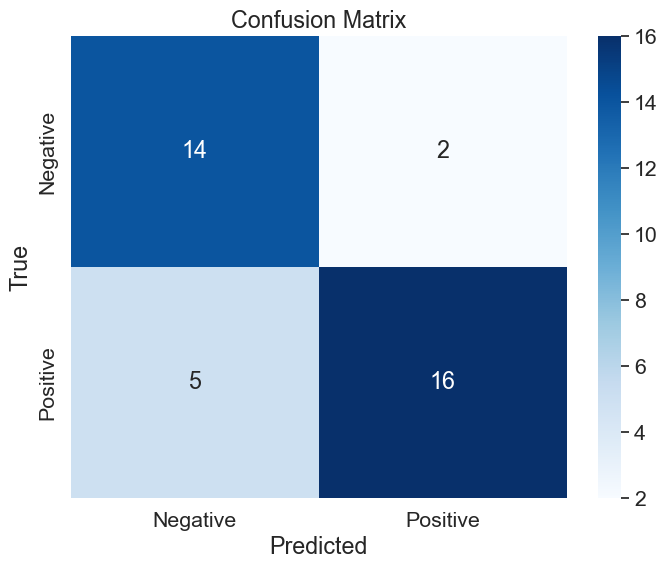

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

0:18:25.617988

Pred proft %: 0.9990459832060596
Gamble proft %: 1.0002941393401341
True proft %: 1.0073939760991395

Look Back: 1 / Total Loss: 4823276.7222808525 / Sold Portion: 0.8333333333333334 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.21581    ', 'TruePrice: 5.019      ', 'GambleProft: 1.039', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20362.82187', 'TruePrice: 20402.59   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.13338    ', 'TruePrice: 3.627      ', 'GambleProft: 1.003', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 478.88246  ', 'TruePrice: 521.3      ', 'GambleProft: 1.008', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.88907    ', 'TruePrice: 0.9151     '

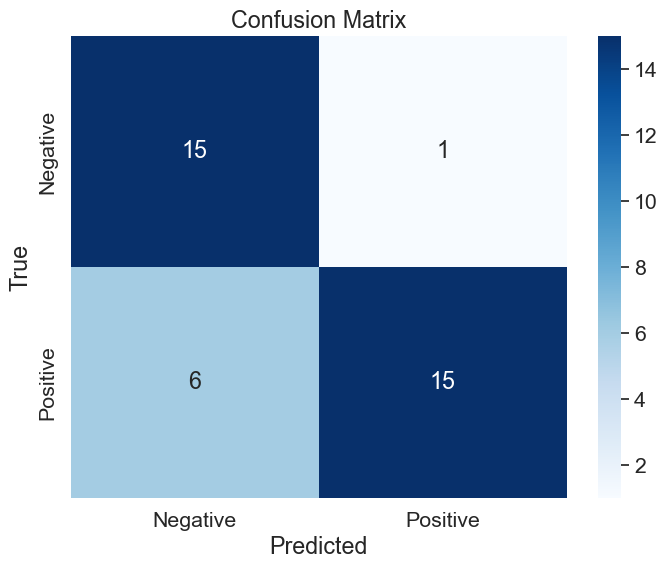

Wrong Buy_Act List:
USDTBRL 

0:18:21.991062

Pred proft %: 1.0031847743531388
Gamble proft %: 1.0021877886981991
True proft %: 1.007233050823758

Look Back: 1 / Total Loss: 2480546.8344959053 / Sold Portion: 0.9285714285714286 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359783.20041', 'TruePrice: 361599.0   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.15755    ', 'TruePrice: 3.627      ', 'GambleProft: 1.011', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.73801   ', 'TruePrice: 55.35      ', 'GambleProft: 1.018', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.78142    ', 'TruePrice: 0.8132     ', 'Gamble

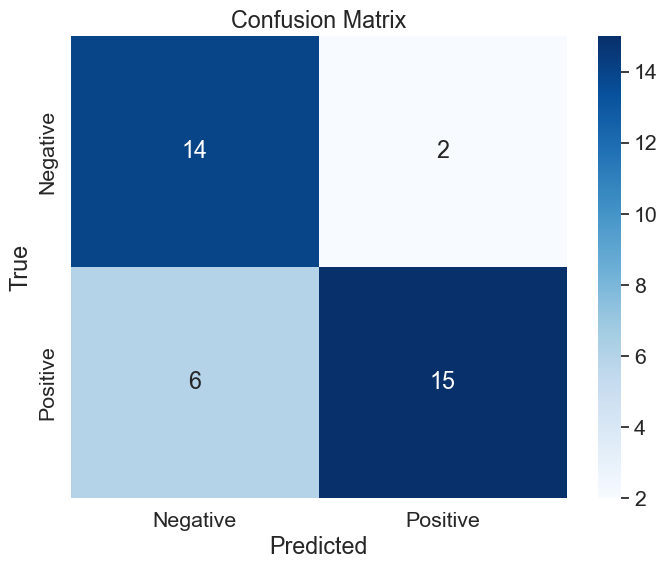

Wrong Buy_Act List:
BNBBRL 

MANABRL 

0:18:25.239380

Pred proft %: 1.0023820837297186
Gamble proft %: 1.0013826810710336
True proft %: 1.0073542733321896

Look Back: 1 / Total Loss: 2523673.239243309 / Sold Portion: 0.7272727272727273 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359443.16578', 'TruePrice: 361599.0   ', 'GambleProft: 1.001', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03387    ', 'TruePrice: 5.019      ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20323.58186', 'TruePrice: 20402.59   ', 'GambleProft: 1.003', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14646    ', 'TruePrice: 3.627      ', 'GambleProft: 1.007', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 481.35716  ', 'TruePrice: 521.3      '

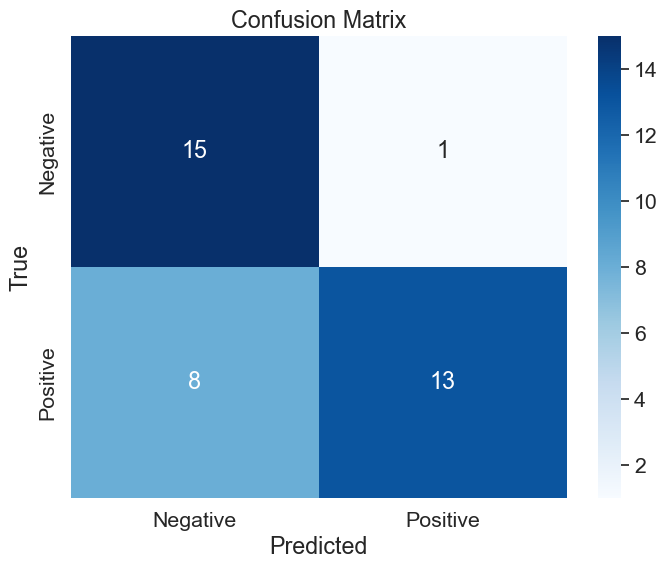

Wrong Buy_Act List:
USDTBRL 

0:18:27.503714

Pred proft %: 0.999819529028187
Gamble proft %: 1.0000202702437908
True proft %: 1.0073060230664928

Look Back: 1 / Total Loss: 4277900.221706619 / Sold Portion: 0.8333333333333334 

['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.71473  ', 'TruePrice: 521.3      ', 'GambleProft: 1.006', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89216    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.012', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.355      ', 'MyGamble: 6.10596    ', 'TruePrice: 1.31       ', 'GambleProft: 4.506', 'TrueProft: 0.967', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.73943   ', 'TruePrice: 19.78      ', 'GambleP

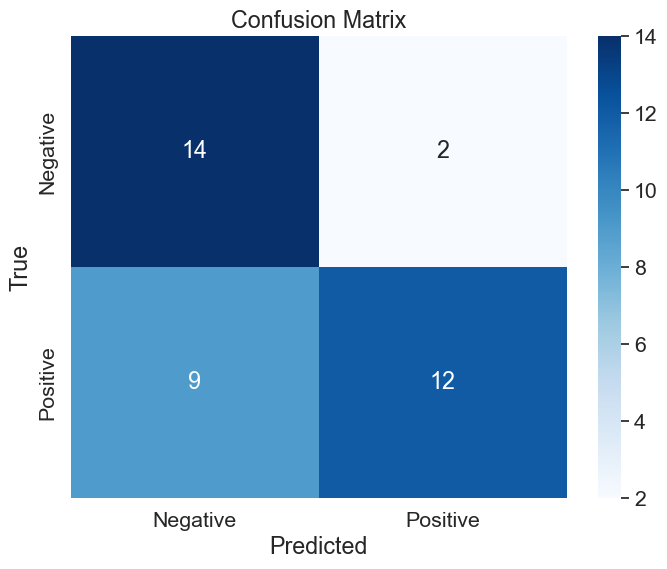

Wrong Buy_Act List:
BNBBRL 

ENJBRL 

0:18:30.774680

Pred proft %: 1.003060605369211
Gamble proft %: 1.0025066674891232
True proft %: 1.0188274002120252

Look Back: 1 / Total Loss: 6354880.7472441 / Sold Portion: 0.9230769230769231 

['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.18648    ', 'TruePrice: 3.627      ', 'GambleProft: 1.02 ', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.74176  ', 'TruePrice: 521.3      ', 'GambleProft: 1.006', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.88959    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.009', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.65135   ', 'TruePrice: 55.35      ', 'GambleProft: 1.017', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.78021    ', 'TruePrice: 0.8132     ', 'Ga

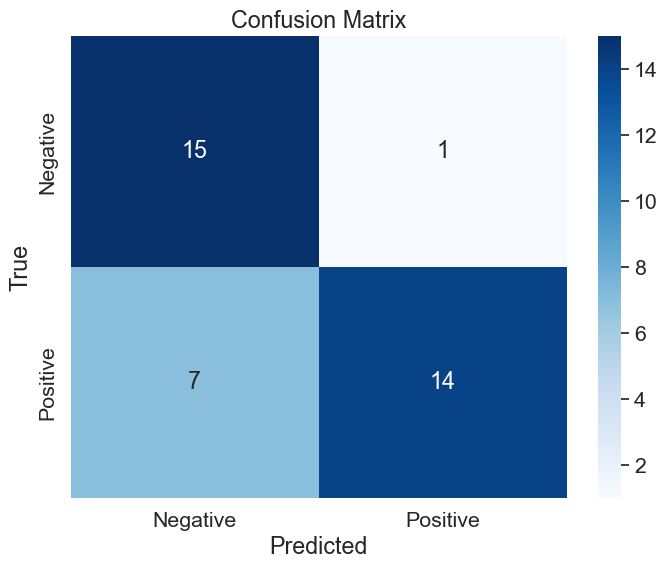

Wrong Buy_Act List:
BNBBRL 

0:18:29.336542

Pred proft %: 1.0024151882244314
Gamble proft %: 1.0014145252267863
True proft %: 1.007273304942016

Look Back: 1 / Total Loss: 2500933.6723046075 / Sold Portion: 0.9285714285714286 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359482.68872', 'TruePrice: 361599.0   ', 'GambleProft: 1.001', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20307.86126', 'TruePrice: 20402.59   ', 'GambleProft: 1.003', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97901    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.1391     ', 'TruePrice: 3.627      ', 'GambleProft: 1.005', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89533    ', 'TruePrice: 0.9151     ', 'GambleP

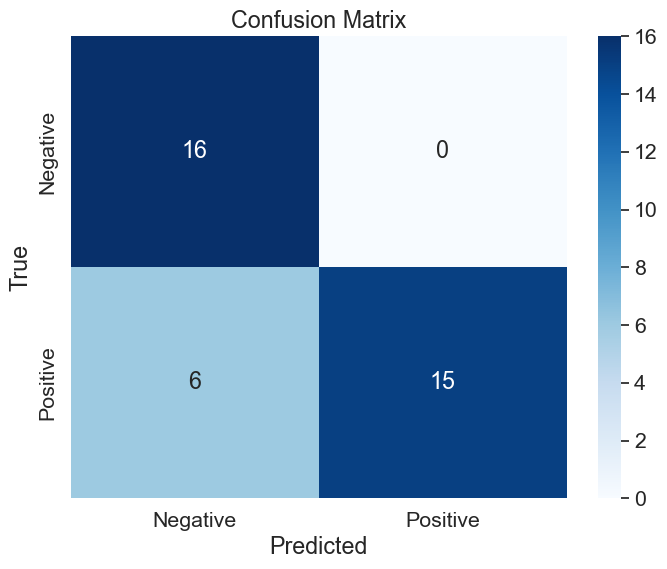

0:18:30.561740

Pred proft %: 0.9976902128156069
Gamble proft %: 1.0000103600326993
True proft %: 1.0072814602943934

Look Back: 1 / Total Loss: 9560065.247773271 / Sold Portion: 1.0 

['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.18648    ', 'TruePrice: 3.627      ', 'GambleProft: 1.02 ', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71777    ', 'TruePrice: 3.884      ', 'GambleProft: 1.003', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01455    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.005', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GambleProft: 1.02 ', 'TrueProft: 1.034', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.04629   ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044', 'SoldStatus

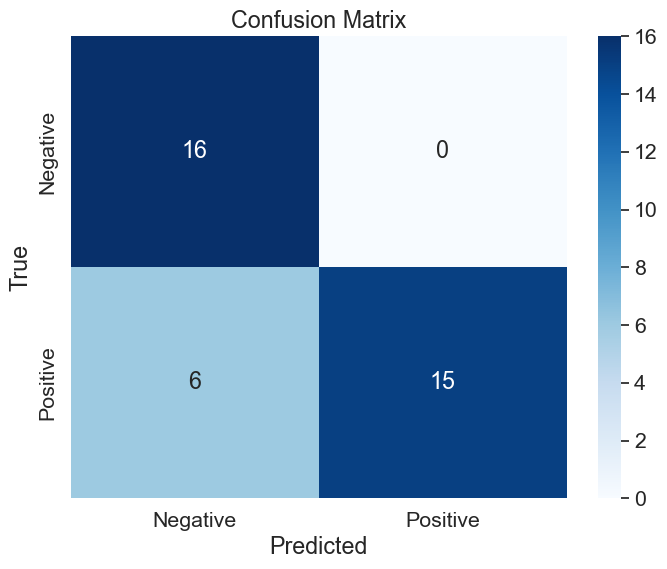

0:18:31.174063


In [18]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 400, lb_list = [1], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [19]:
get_avg_gamble(verify_list)

XRPBRL / Gamble: 3.1567356242489812 / TruePrice: 3.627 / SoldStatus: True / GambleProft: 1.0104787529606214
LTCBRL / Gamble: 478.43655496215825 / TruePrice: 521.3 / SoldStatus: True / GambleProft: 1.0072348525519121
DOGEBRL / Gamble: 0.891199280843258 / TruePrice: 0.9151 / SoldStatus: True / GambleProft: 1.011232589178779
CAKEBRL / Gamble: 67.02988518608942 / TruePrice: 69.73 / SoldStatus: True / GambleProft: 1.003591633269792
AXSBRL / Gamble: 38.29176712036133 / TruePrice: 38.75 / SoldStatus: True / GambleProft: 1.0050332577522658
GMTBRL / Gamble: 1.3322003287506103 / TruePrice: 1.337 / SoldStatus: True / GambleProft: 1.0115416315494383
GALBRL / Gamble: 8.426180005073547 / TruePrice: 8.72 / SoldStatus: True / GambleProft: 1.006712067511774
SANTOSBRL / Gamble: 19.7419610861642 / TruePrice: 19.78 / SoldStatus: True / GambleProft: 1.011889343217027
AVAXBRL / Gamble: 234.50653738149012 / TruePrice: 245.9 / SoldStatus: True / GambleProft: 1.0090642744470315


{'XRPBRL': 3.1567356242489812,
 'LTCBRL': 478.43655496215825,
 'DOGEBRL': 0.891199280843258,
 'CAKEBRL': 67.02988518608942,
 'AXSBRL': 38.29176712036133,
 'GMTBRL': 1.3322003287506103,
 'GALBRL': 8.426180005073547,
 'SANTOSBRL': 19.7419610861642,
 'AVAXBRL': 234.50653738149012}


Pred proft %: 1.0089925921381058
Gamble proft %: 1.0079870209609036
True proft %: 1.00736199461502

Look Back: 1 / Total Loss: 7294970.046467601 / Sold Portion: 0.9166666666666666 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 361860.46481', 'TruePrice: 361599.0   ', 'GambleProft: 1.008', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14296    ', 'TruePrice: 3.627      ', 'GambleProft: 1.006', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 476.298    ', 'TruePrice: 521.3      ', 'GambleProft: 1.003', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71755    ', 'TruePrice: 3.884      ', 'GambleProft: 1.003', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.25725   ', 'TruePrice: 55.35      ', 'GambleProft: 1.009', 'TrueProft: 1.03 ', 'SoldStatus:

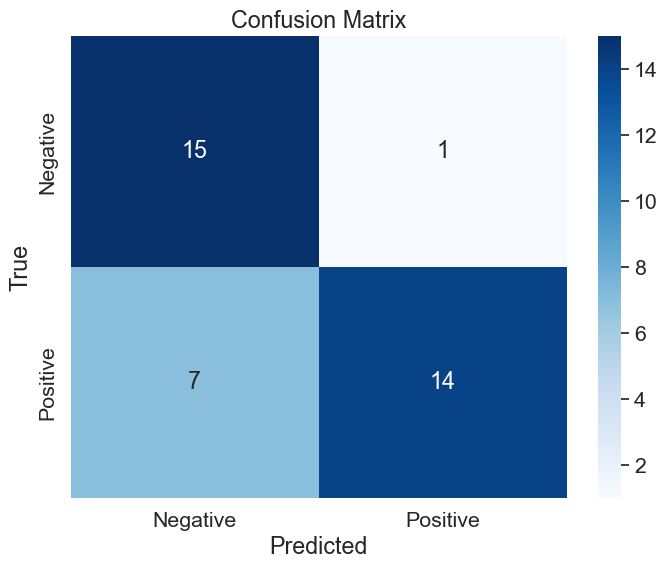

Wrong Buy_Act List:
USDTBRL 

0:22:45.092036

Pred proft %: 1.0031005395557933
Gamble proft %: 1.0022592896913431
True proft %: 1.0073535085498277

Look Back: 1 / Total Loss: 2492336.1348240273 / Sold Portion: 0.8333333333333334 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359848.97831', 'TruePrice: 361599.0   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 479.22756  ', 'TruePrice: 521.3      ', 'GambleProft: 1.009', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89181    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.012', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72417    ', 'TruePrice: 3.884      ', 'GambleProft: 1.004', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.92817   ', 'TruePrice: 55.35      ', 'Gambl

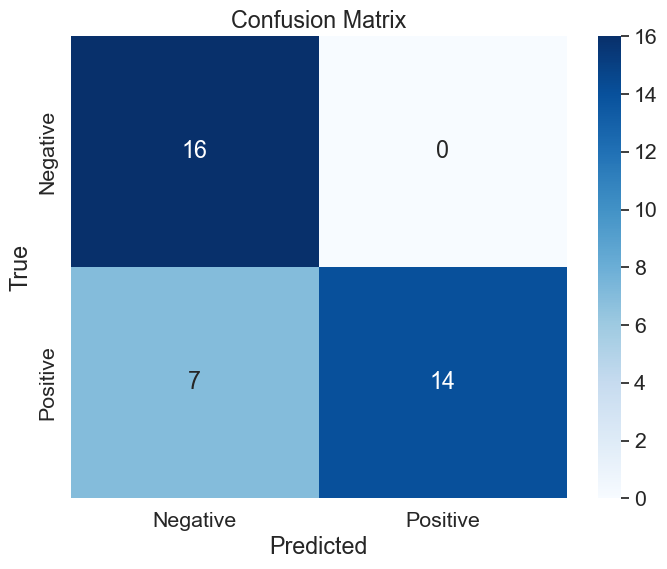

0:22:48.616277

Pred proft %: 0.9997924424790285
Gamble proft %: 1.0000253051087897
True proft %: 1.0072743953017942

Look Back: 1 / Total Loss: 3722269.5606871117 / Sold Portion: 0.9 

['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71288    ', 'TruePrice: 3.884      ', 'GambleProft: 1.001', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.98982   ', 'TruePrice: 55.35      ', 'GambleProft: 1.004', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GambleProft: 1.02 ', 'TrueProft: 1.034', 'SoldStatus: 1', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 745.5      ', 'MyGamble: 753.43087  ', 'TruePrice: 746.9      ', 'GambleProft: 1.011', 'TrueProft: 1.002', 'SoldStatus: 0', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.24497   ', 'TruePrice: 69.73      ', 'GambleProft: 1.007', 'TrueProft: 1.044', 'SoldStatu

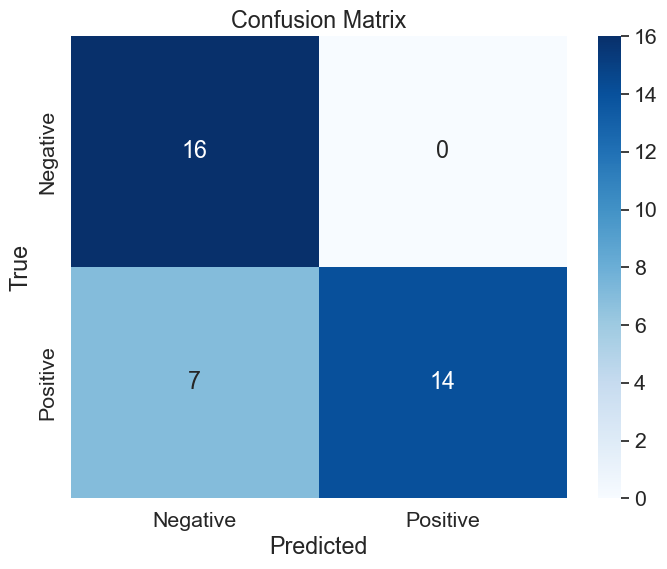

0:22:51.841936

Pred proft %: 0.9995176932944041
Gamble proft %: 1.0003495850377453
True proft %: 1.007235646111768

Look Back: 1 / Total Loss: 4280150.2918331195 / Sold Portion: 0.8181818181818182 

['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.13496    ', 'TruePrice: 3.627      ', 'GambleProft: 1.004', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89364    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.014', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77769    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.015', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GambleProft: 1.02 ', 'TrueProft: 1.03

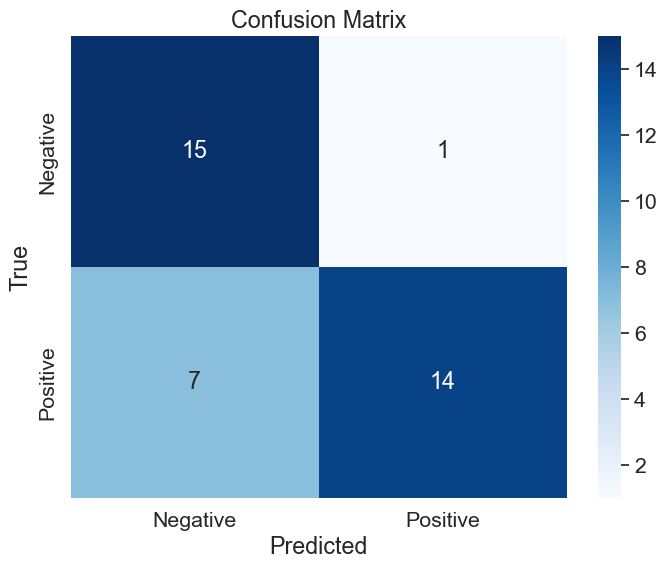

Wrong Buy_Act List:
LUNABRL 

0:22:51.662356

Pred proft %: 1.0064144762744198
Gamble proft %: 1.0054137415125477
True proft %: 1.0073514704506137

Look Back: 1 / Total Loss: 4010802.440387917 / Sold Portion: 0.9230769230769231 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 360901.95553', 'TruePrice: 361599.0   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20408.50856', 'TruePrice: 20402.59   ', 'GambleProft: 1.008', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14366    ', 'TruePrice: 3.627      ', 'GambleProft: 1.006', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 480.04087  ', 'TruePrice: 521.3      ', 'GambleProft: 1.011', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89016    ', 'TruePrice: 0.9151     ', 'Gamble

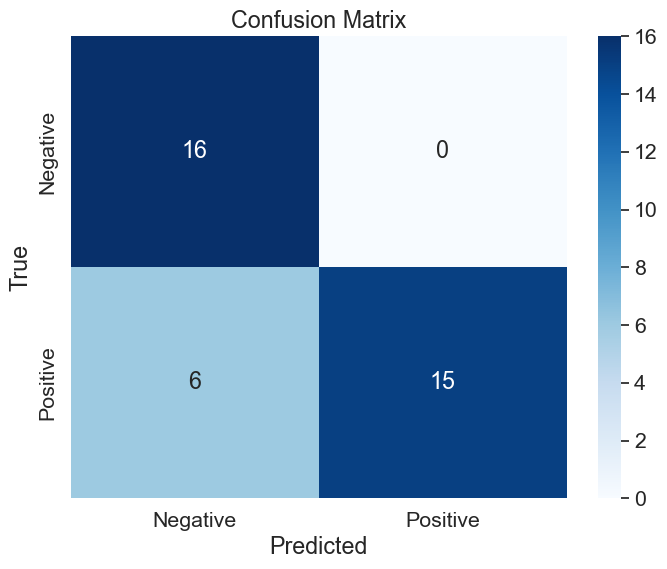

0:22:50.718553

Pred proft %: 0.9993378658113905
Gamble proft %: 1.0001149760627122
True proft %: 1.0073918255685592

Look Back: 1 / Total Loss: 4292761.898663728 / Sold Portion: 0.8 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20294.65963', 'TruePrice: 20402.59   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.74372  ', 'TruePrice: 521.3      ', 'GambleProft: 1.006', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89018    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.01 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72684    ', 'TruePrice: 3.884      ', 'GambleProft: 1.005', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GambleProft: 1.02 ', 'TrueProft: 1.034', 'SoldStatus

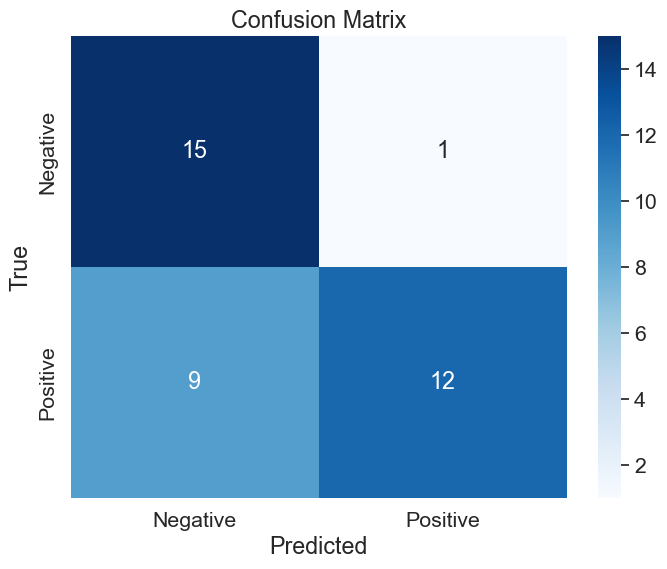

Wrong Buy_Act List:
USDTBRL 

0:22:56.114495

Pred proft %: 1.0002377389825834
Gamble proft %: 1.0004187602129921
True proft %: 1.0073556083071886

Look Back: 1 / Total Loss: 3757435.736398404 / Sold Portion: 0.8461538461538461 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20411.3163 ', 'TruePrice: 20402.59   ', 'GambleProft: 1.008', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.13044    ', 'TruePrice: 3.627      ', 'GambleProft: 1.002', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.28452  ', 'TruePrice: 521.3      ', 'GambleProft: 1.005', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89845    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.019', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71463    ', 'TruePrice: 3.884      ', 'GambleP

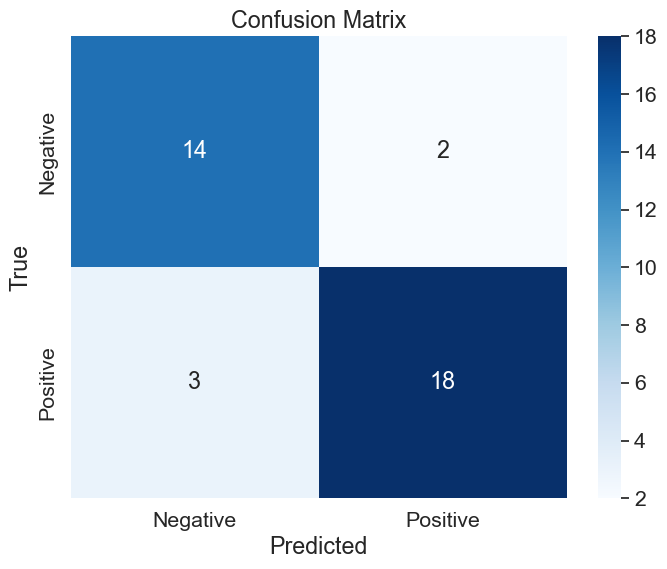

Wrong Buy_Act List:
USDTBRL 

HOTBRL 

0:22:57.757812

Pred proft %: 1.0068302110089553
Gamble proft %: 1.0058365061513521
True proft %: 1.0082842288317253

Look Back: 1 / Total Loss: 9093740.089852896 / Sold Portion: 1.0 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20391.27581', 'TruePrice: 20402.59   ', 'GambleProft: 1.007', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97867    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.7755     ', 'TruePrice: 0.8132     ', 'GambleProft: 1.012', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GambleProft: 1.02 ', 'TrueProft: 1.034', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.13       ', 'MyGamble: 6.17677    ', 'TruePrice: 6.229      ', 'GambleProft: 

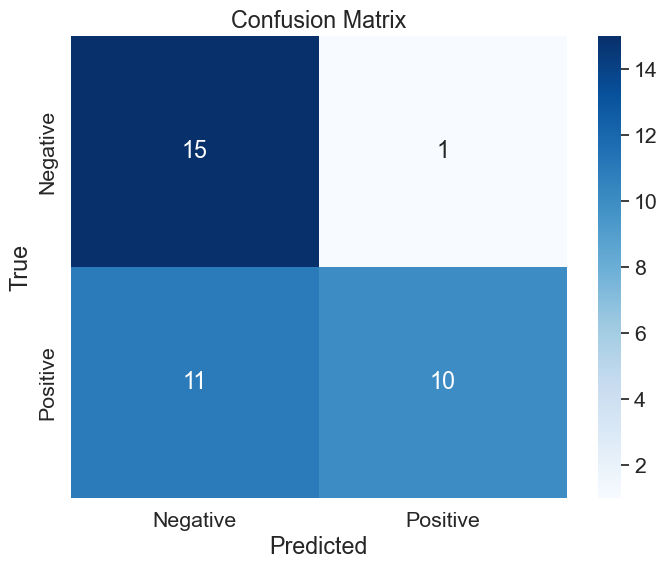

Wrong Buy_Act List:
BNBBRL 

0:22:56.745773

Pred proft %: 0.9995494153473725
Gamble proft %: 1.0000124194916578
True proft %: 1.0074060087032384

Look Back: 1 / Total Loss: 3993348.8365809903 / Sold Portion: 1.0 

['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14637    ', 'TruePrice: 3.627      ', 'GambleProft: 1.007', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.34207  ', 'TruePrice: 521.3      ', 'GambleProft: 1.005', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89099    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.011', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.74336   ', 'TruePrice: 55.35      ', 'GambleProft: 1.018', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77036    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.006', '

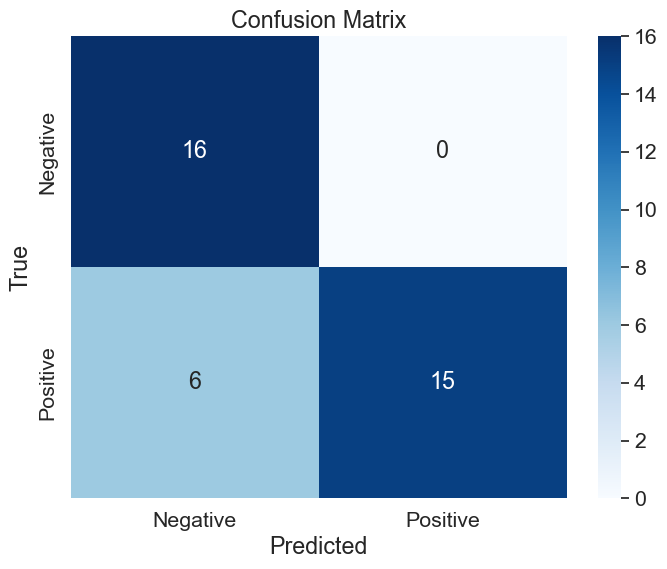

0:23:14.782494

Pred proft %: 0.998435901574061
Gamble proft %: 1.0000052469537155
True proft %: 1.0072529492306335

Look Back: 1 / Total Loss: 5060656.468689732 / Sold Portion: 0.8 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.2177     ', 'TruePrice: 5.019      ', 'GambleProft: 1.039', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.15273    ', 'TruePrice: 3.627      ', 'GambleProft: 1.009', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 4.38564    ', 'TruePrice: 3.884      ', 'GambleProft: 1.183', 'TrueProft: 1.047', 'SoldStatus: 0', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.81899   ', 'TruePrice: 55.35      ', 'GambleProft: 1.001', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77301    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.009', 'TrueProft: 1.061', 'SoldStatus:

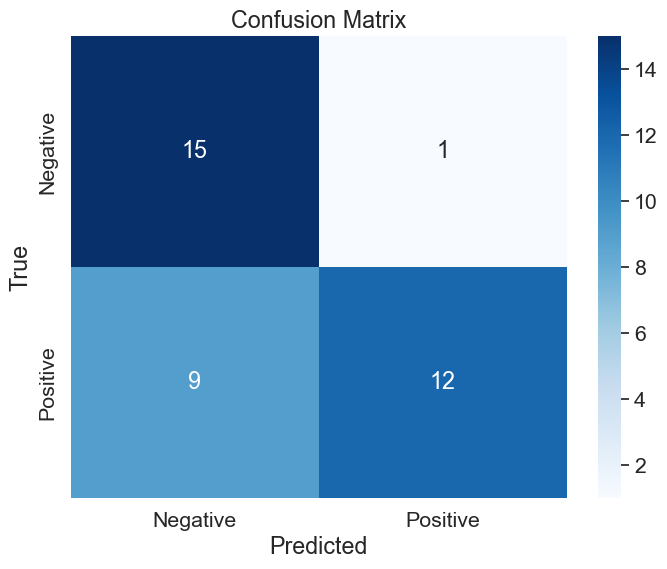

Wrong Buy_Act List:
USDTBRL 

0:23:17.290589


In [20]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 500, lb_list = [1], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [21]:
get_avg_gamble(verify_list)

XRPBRL / Gamble: 3.1418529482682547 / TruePrice: 3.627 / SoldStatus: True / GambleProft: 1.0057147721729367
LTCBRL / Gamble: 477.9894544881185 / TruePrice: 521.3 / SoldStatus: True / GambleProft: 1.0062935883960389
ADABRL / Gamble: 3.8302836763064065 / TruePrice: 3.884 / SoldStatus: True / GambleProft: 1.0329783377309618
DOTBRL / Gamble: 54.193520863850914 / TruePrice: 55.35 / SoldStatus: True / GambleProft: 1.0080640041638935
CAKEBRL / Gamble: 67.27258491516113 / TruePrice: 69.73 / SoldStatus: True / GambleProft: 1.0072254067249757
AXSBRL / Gamble: 38.54278882344564 / TruePrice: 38.75 / SoldStatus: True / GambleProft: 1.011621753896211
GMTBRL / Gamble: 1.3316521315066019 / TruePrice: 1.337 / SoldStatus: True / GambleProft: 1.0111253845911936
GALBRL / Gamble: 8.579650196790695 / TruePrice: 8.72 / SoldStatus: True / GambleProft: 1.0250478132366423
DOGEBRL / Gamble: 0.8925379514694214 / TruePrice: 0.9151 / SoldStatus: True / GambleProft: 1.0127515618625003
CHZBRL / Gamble: 0.773858432590

{'XRPBRL': 3.1418529482682547,
 'LTCBRL': 477.9894544881185,
 'ADABRL': 3.8302836763064065,
 'DOTBRL': 54.193520863850914,
 'CAKEBRL': 67.27258491516113,
 'AXSBRL': 38.54278882344564,
 'GMTBRL': 1.3316521315066019,
 'GALBRL': 8.579650196790695,
 'DOGEBRL': 0.8925379514694214,
 'CHZBRL': 0.7738584325909615,
 'WINBRL': 0.000988788,
 'SANTOSBRL': 19.82565055135091}


Pred proft %: 1.0093131370077844
Gamble proft %: 1.009198186837218
True proft %: 1.0412308351993973

Look Back: 2 / Total Loss: 25344654.209047828 / Sold Portion: 0.6666666666666666 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.02774    ', 'TruePrice: 5.019      ', 'GambleProft: 1.001', 'TrueProft: 0.999', 'SoldStatus: 1', 'CorrectModel: 0']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 476.43461  ', 'TruePrice: 521.3      ', 'GambleProft: 1.003', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01464    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.011', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00158    ', 'TruePrice: 0.001      ', 'GambleProft: 1.632', 'TrueProft: 1.034', 'SoldStatus

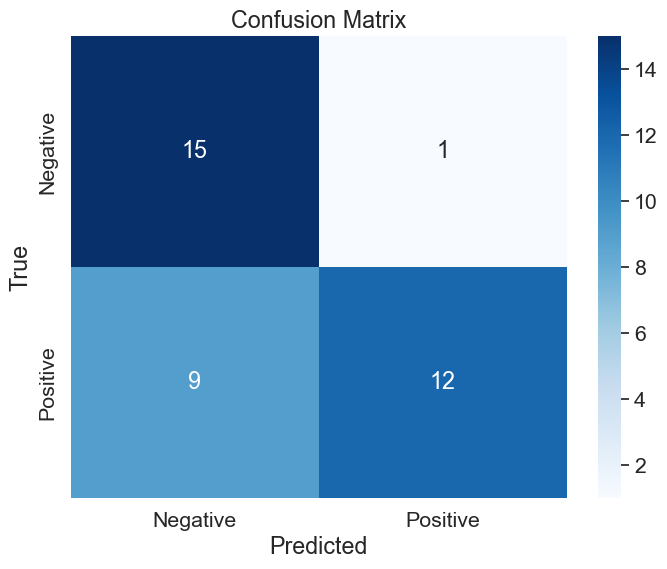

Wrong Buy_Act List:
USDTBRL 

0:12:07.741326

Pred proft %: 0.9986123578370082
Gamble proft %: 1.0001750631212234
True proft %: 1.007336307729397

Look Back: 2 / Total Loss: 5093395.431384073 / Sold Portion: 0.6666666666666666 

['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2663.66838 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.016', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 479.79352  ', 'TruePrice: 521.3      ', 'GambleProft: 1.01 ', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GamblePr

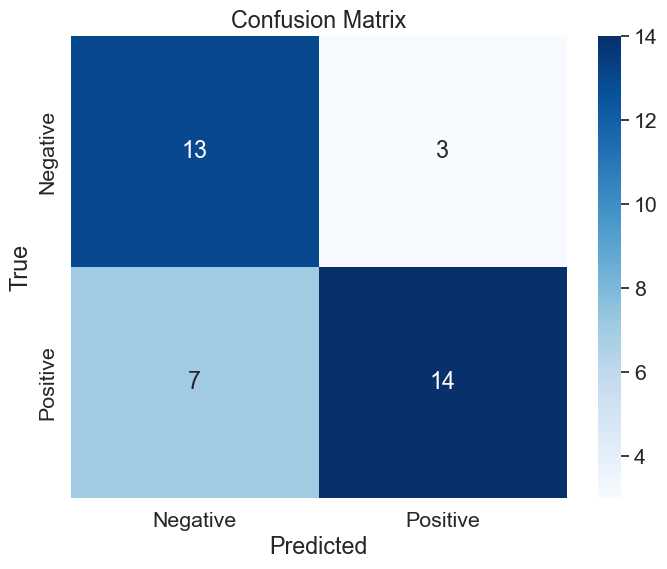

Wrong Buy_Act List:
BNBBRL 

SHIBBRL 

FISBRL 

0:12:07.448556

Pred proft %: 1.0037945973983913
Gamble proft %: 1.0028374743453463
True proft %: 1.0084691616040455

Look Back: 2 / Total Loss: 11602672.928198054 / Sold Portion: 1.0 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20314.92646', 'TruePrice: 20402.59   ', 'GambleProft: 1.003', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97851    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 480.06067  ', 'TruePrice: 521.3      ', 'GambleProft: 1.011', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.27213   ', 'TruePrice: 55.35      ', 'Gam

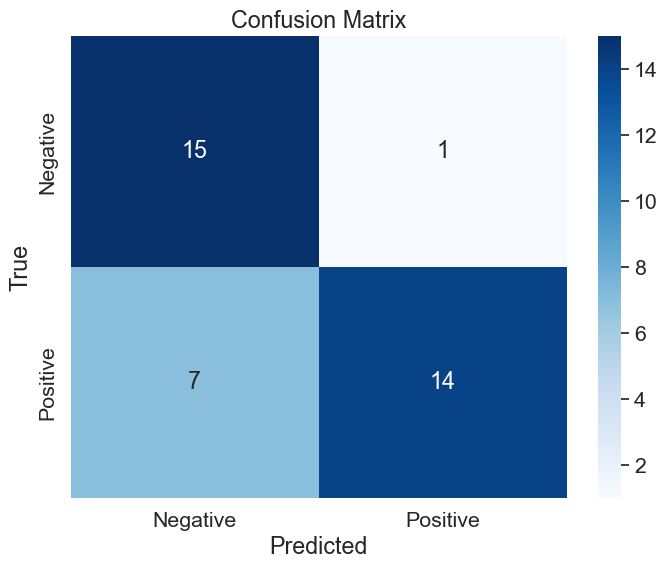

Wrong Buy_Act List:
BNBBRL 

0:12:04.626165

Pred proft %: 0.998516581347892
Gamble proft %: 1.0000024839393296
True proft %: 1.0072519534085047

Look Back: 2 / Total Loss: 4967963.98854441 / Sold Portion: 0.5 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03596    ', 'TruePrice: 5.019      ', 'GambleProft: 1.003', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.12763   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.25052   ', 'TruePrice: 38.75      ', 'GambleProft: 1.004', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.9002    ', 'TruePrice: 19.78      ', 'GambleProft: 1.02 ', 'TrueProft: 1.014', 'SoldStatus: 0', 'CorrectModel: 1']
CM accuracy: 0.6486486486486487


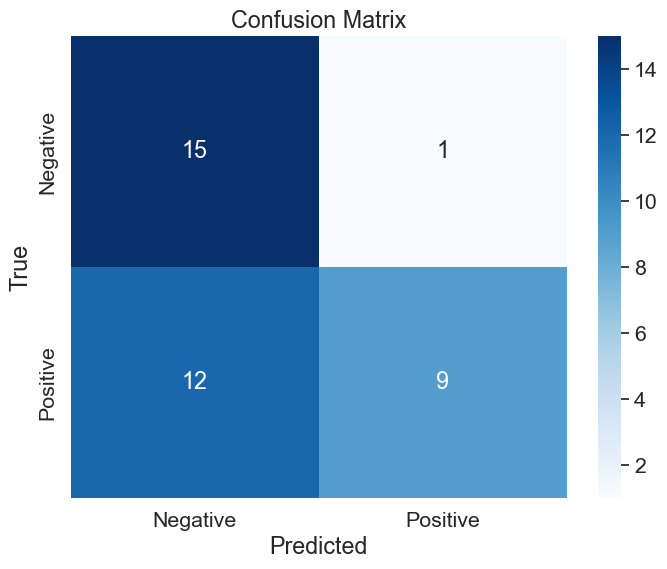

Wrong Buy_Act List:
USDTBRL 

0:12:09.831561

Pred proft %: 1.0137493020369668
Gamble proft %: 1.0129914868064163
True proft %: 1.0053857125929098

Look Back: 2 / Total Loss: 19674828.849652905 / Sold Portion: 0.5555555555555556 

['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2646.60124 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.009', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.73378    ', 'TruePrice: 3.884      ', 'GambleProft: 1.007', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77359    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.01 ', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01465    ', 'TruePrice: 0.01493    ', 'Gamble

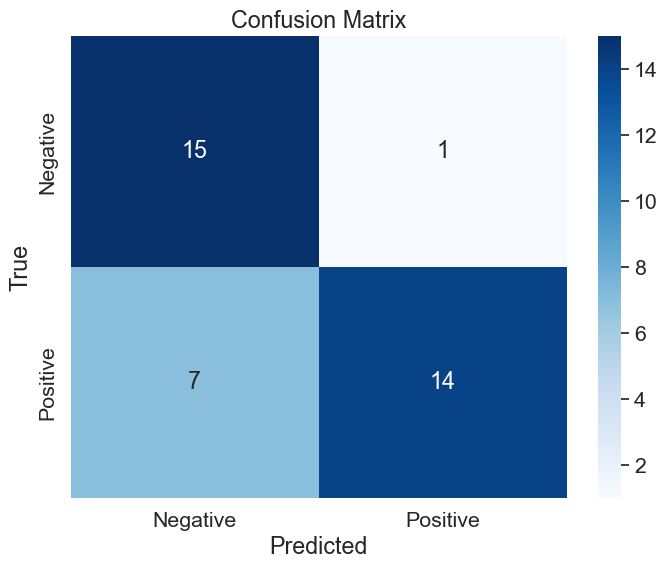

Wrong Buy_Act List:
BNBBRL 

0:12:08.737319

Pred proft %: 1.0029976434600805
Gamble proft %: 1.001999096251936
True proft %: 1.0073527844097416

Look Back: 2 / Total Loss: 3532087.9180808626 / Sold Portion: 0.75 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359715.58059', 'TruePrice: 361599.0   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03153    ', 'TruePrice: 5.019      ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 479.10561  ', 'TruePrice: 521.3      ', 'GambleProft: 1.009', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.8851     ', 'TruePrice: 0.9151     ', 'GambleProft: 1.004', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.13       ', 'MyGamble: 6.17861    ', 'TruePrice: 6.229      ', 'GambleProft: 1.008', 

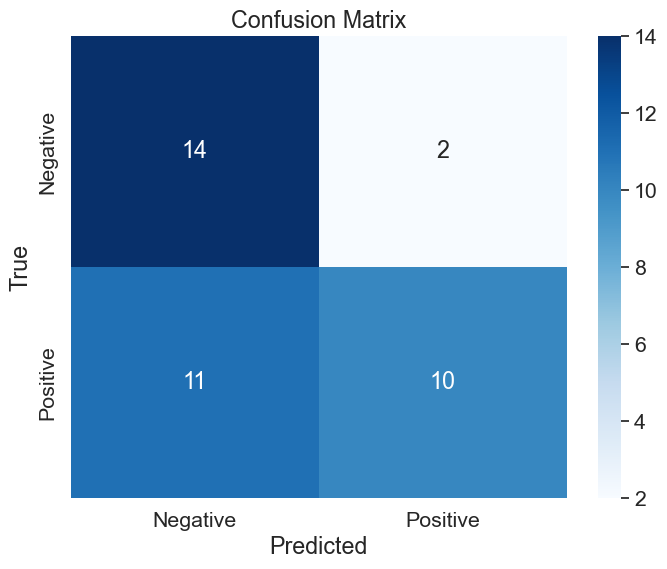

Wrong Buy_Act List:
USDTBRL 

FISBRL 

0:12:08.327134

Pred proft %: 1.002002255100557
Gamble proft %: 1.0010007015251832
True proft %: 1.0072016687758212

Look Back: 2 / Total Loss: 2784892.742555347 / Sold Portion: 0.6666666666666666 

['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2627.51    ', 'TruePrice: 2622.0     ', 'GambleProft: 1.002', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.17668    ', 'TruePrice: 3.627      ', 'GambleProft: 1.017', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.71943    ', 'TruePrice: 3.884      ', 'GambleProft: 1.003', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.08075   ', 'TruePrice: 55.35      ', 'GambleProft: 1.006', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01454    ', 'TruePrice: 0.01493    ', 

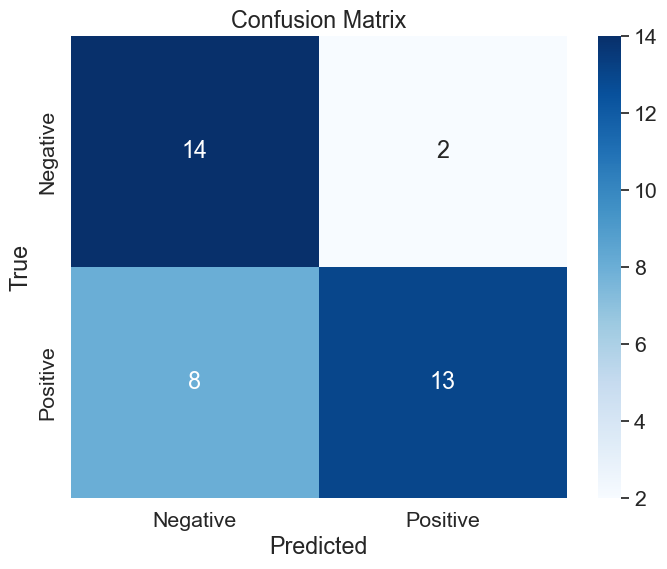

Wrong Buy_Act List:
BNBBRL 

SHIBBRL 

0:12:10.546039

Pred proft %: 1.0058383843433283
Gamble proft %: 1.0049026280802793
True proft %: 1.0073094747791886

Look Back: 2 / Total Loss: 4443366.50715776 / Sold Portion: 0.7142857142857143 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 360850.13241', 'TruePrice: 361599.0   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2646.26637 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.009', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.76235    ', 'TruePrice: 3.884      ', 'GambleProft: 1.015', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77577    ', 'TruePrice: 0.8132     ',

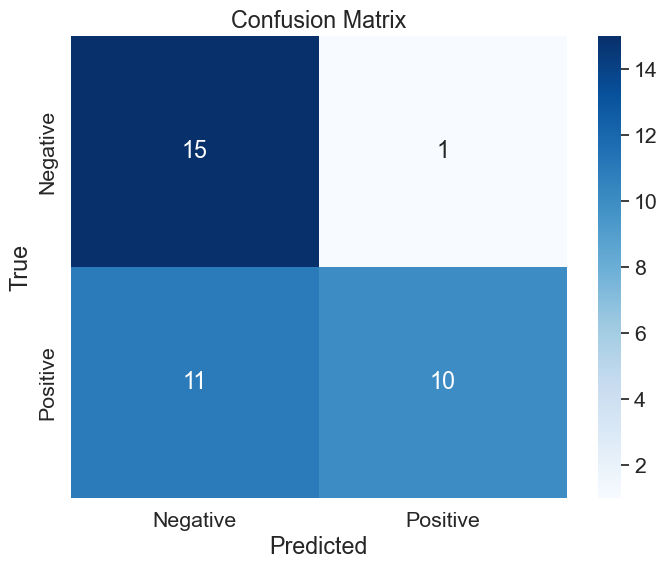

Wrong Buy_Act List:
BNBBRL 

0:12:13.505526

Pred proft %: 1.0023392800163795
Gamble proft %: 1.0013882300957104
True proft %: 1.0018391211889404

Look Back: 2 / Total Loss: 7545612.936691294 / Sold Portion: 0.8181818181818182 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03222    ', 'TruePrice: 5.019      ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.18648    ', 'TruePrice: 3.627      ', 'GambleProft: 1.02 ', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.0147     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.015', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GamblePr

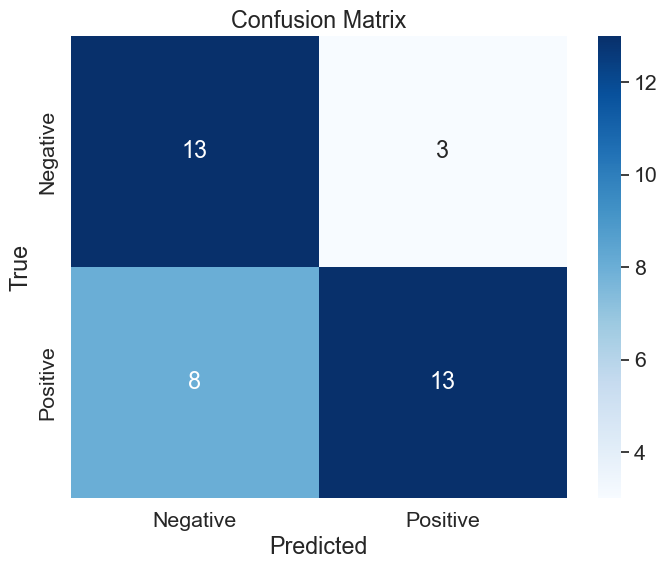

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

FISBRL 

0:12:14.090329

Pred proft %: 1.002972434317021
Gamble proft %: 1.002012176535923
True proft %: 1.0084700816030097

Look Back: 2 / Total Loss: 36551701.44442293 / Sold Portion: 0.8 

['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2646.32198 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.009', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.16897    ', 'TruePrice: 3.627      ', 'GambleProft: 1.014', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 481.90168  ', 'TruePrice: 521.3      ', 'GambleProft: 1.015', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89423    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.015', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.75023    ', 'TruePrice: 3.884      ', 'Gamble

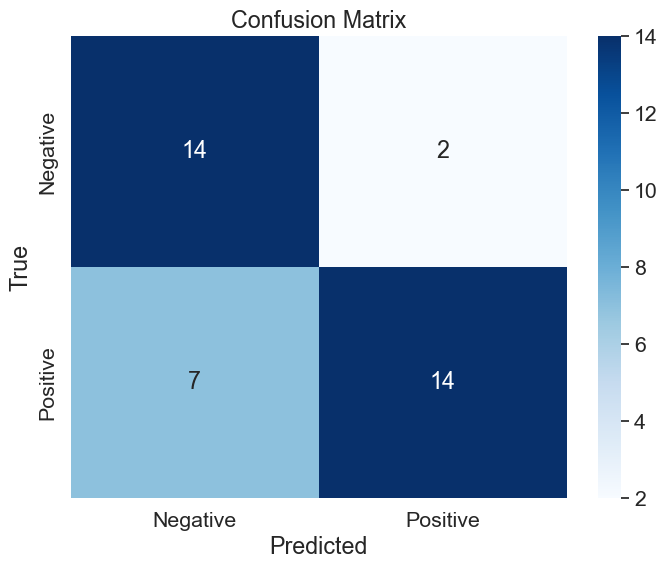

Wrong Buy_Act List:
BNBBRL 

FISBRL 

0:12:10.895945


In [22]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 200, lb_list = [2], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [23]:
get_avg_gamble(verify_list)

DOGEBRL / Gamble: 0.8966106475896836 / TruePrice: 0.9151 / SoldStatus: True / GambleProft: 1.0173727988082193
BTTBRL / Gamble: 0.0146769109007438 / TruePrice: 0.01493 / SoldStatus: True / GambleProft: 1.013598819112141
WINBRL / Gamble: 0.0010875942838566937 / TruePrice: 0.0010019 / SoldStatus: False / GambleProft: 1.1219251948181284
CAKEBRL / Gamble: 67.33957946777343 / TruePrice: 69.73 / SoldStatus: True / GambleProft: 1.008228469348307
AXSBRL / Gamble: 38.44297033691406 / TruePrice: 38.75 / SoldStatus: True / GambleProft: 1.0090018461132297
SANTOSBRL / Gamble: 19.77833022206624 / TruePrice: 19.78 / SoldStatus: True / GambleProft: 1.0137534711463987
GMTBRL / Gamble: 1.3463076909899707 / TruePrice: 1.337 / SoldStatus: False / GambleProft: 1.0222533720500917


{'DOGEBRL': 0.8966106475896836,
 'BTTBRL': 0.0146769109007438,
 'WINBRL': 0.0010875942838566937,
 'CAKEBRL': 67.33957946777343,
 'AXSBRL': 38.44297033691406,
 'SANTOSBRL': 19.77833022206624,
 'GMTBRL': 1.3463076909899707}


Pred proft %: 1.0074517697373115
Gamble proft %: 1.0065210073712523
True proft %: 1.0099805099600945

Look Back: 2 / Total Loss: 37884217.17654035 / Sold Portion: 0.9166666666666666 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03596    ', 'TruePrice: 5.019      ', 'GambleProft: 1.003', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20387.56468', 'TruePrice: 20402.59   ', 'GambleProft: 1.006', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 479.00327  ', 'TruePrice: 521.3      ', 'GambleProft: 1.008', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72478    ', 'TruePrice: 3.884      ', 'GambleProft: 1.005', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.78142    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.02 ', 'TrueProft: 1.061', 'SoldStatus

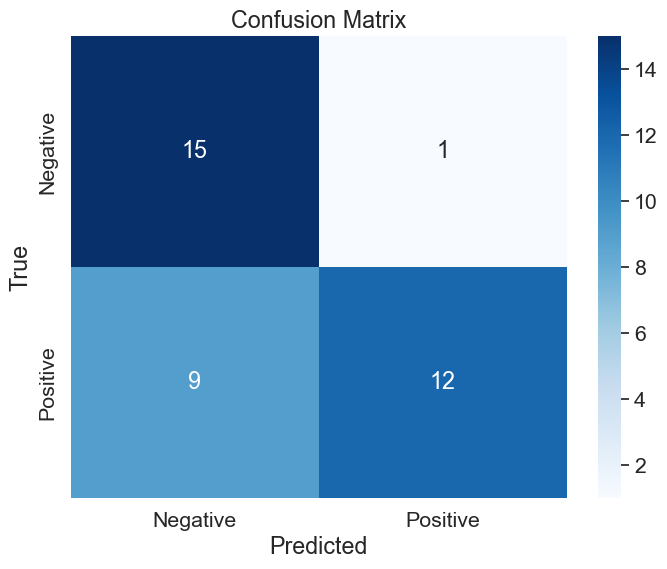

Wrong Buy_Act List:
USDTBRL 

0:17:34.022864

Pred proft %: 0.9976871990403283
Gamble proft %: 1.0000047748108016
True proft %: 1.0073731714376901

Look Back: 2 / Total Loss: 6051201.067923888 / Sold Portion: 0.9166666666666666 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.05359    ', 'TruePrice: 5.019      ', 'GambleProft: 1.006', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.18235    ', 'TruePrice: 3.627      ', 'GambleProft: 1.019', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.726      ', 'TruePrice: 3.884      ', 'GambleProft: 1.005', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.35057   ', 'TruePrice: 55.35      ', 'GambleP

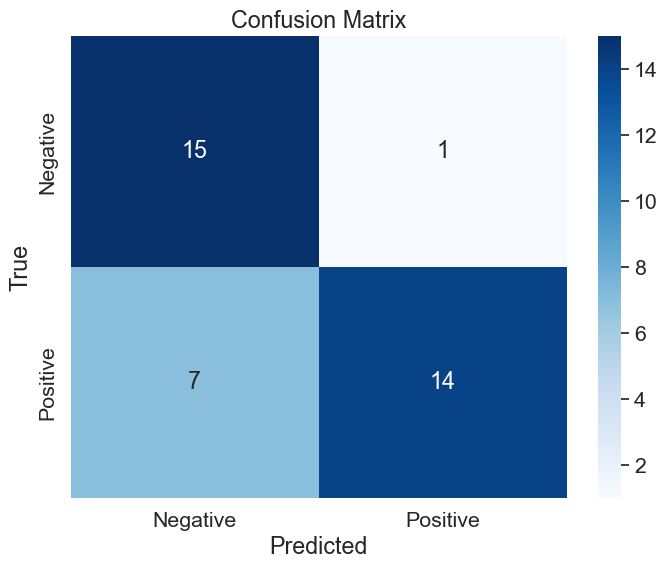

Wrong Buy_Act List:
USDTBRL 

0:17:49.975294

Pred proft %: 1.002657770070802
Gamble proft %: 1.0016580144834026
True proft %: 1.0073082079270241

Look Back: 2 / Total Loss: 3173550.141396481 / Sold Portion: 0.75 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20511.57727', 'TruePrice: 20402.59   ', 'GambleProft: 1.013', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2654.09252 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.012', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.13629    ', 'TruePrice: 3.627      ', 'GambleProft: 1.004', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 476.10725  ', 'TruePrice: 521.3      ', 'GambleProft: 1.002', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 53.90227   ', 'TruePrice: 55.35      ', 'GambleProft: 1.003', '

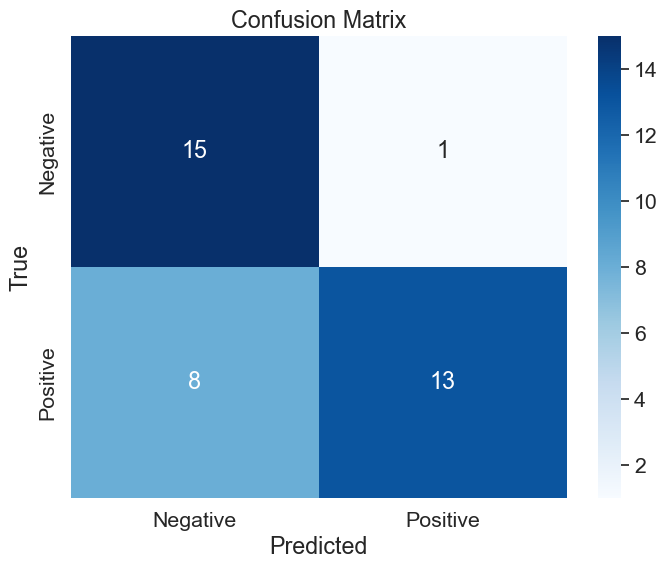

Wrong Buy_Act List:
BNBBRL 

0:18:53.920460

Pred proft %: 1.0032753626442728
Gamble proft %: 1.0021856870676902
True proft %: 1.0010221261281533

Look Back: 2 / Total Loss: 29741475.333502203 / Sold Portion: 0.7142857142857143 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03073    ', 'TruePrice: 5.019      ', 'GambleProft: 1.002', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2626.88855 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.002', 'TrueProft: 1.0  ', 'SoldStatus: 1', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14892    ', 'TruePrice: 3.627      ', 'GambleProft: 1.008', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72014    ', 'TruePrice: 3.884      ', 'GambleP

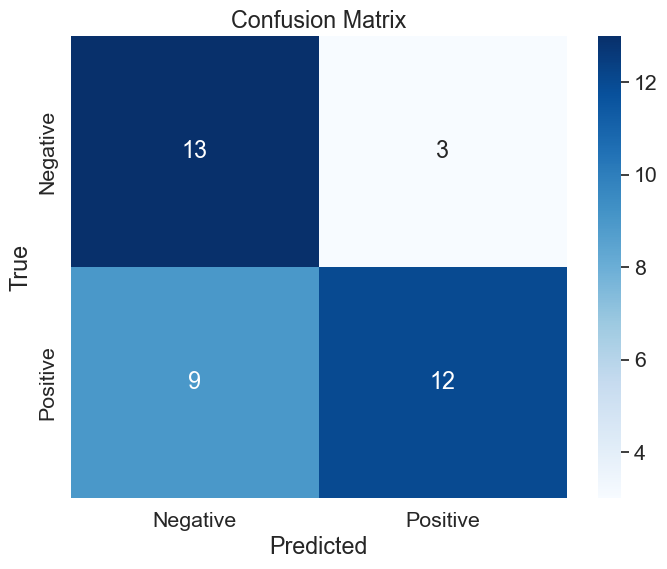

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

HOTBRL 

0:19:34.129217

Pred proft %: 1.0001185692878993
Gamble proft %: 1.000004251930598
True proft %: 1.00724923316384

Look Back: 2 / Total Loss: 416222024.778381 / Sold Portion: 0.8571428571428571 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 5.01077    ', 'TruePrice: 4.977      ', 'GambleProft: 1.008', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.13636    ', 'TruePrice: 3.627      ', 'GambleProft: 1.004', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     ', 'GambleProft: 1.02 ', 'TrueProft: 1.038', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 68.02637   ', 'TruePrice: 69.73   

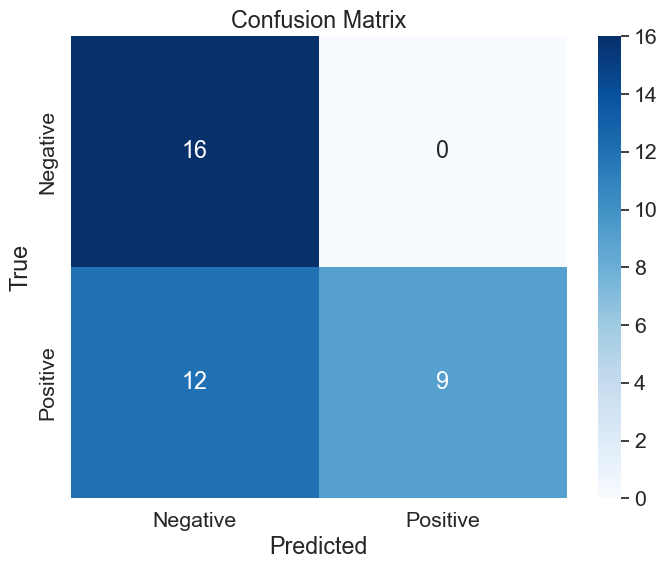

0:19:26.283227

Pred proft %: 1.0006974072276753
Gamble proft %: 1.0000042324620813
True proft %: 1.0072810703426835

Look Back: 2 / Total Loss: 3413871.4209120977 / Sold Portion: 0.7777777777777778 

['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.0293     ', 'TruePrice: 5.019      ', 'GambleProft: 1.001', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.17997    ', 'TruePrice: 3.627      ', 'GambleProft: 1.018', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7661     ', 'MyGamble: 0.77085    ', 'TruePrice: 0.8132     ', 'GambleProft: 1.006', 'TrueProft: 1.061', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['SHIBBRL ', 'LastPrice: 0.00017    ', 'MyGamble: 0.00017    ', 'TruePrice: 0.00017    ', 'GambleProft: 1.021', 'TrueProft: 0.9

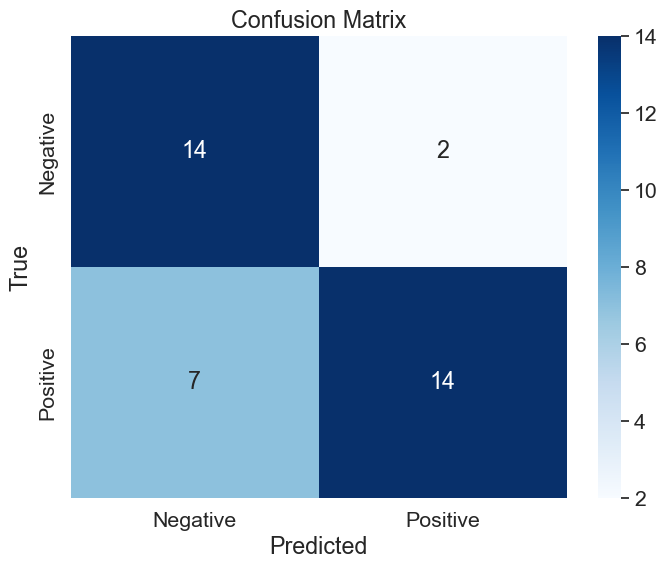

Wrong Buy_Act List:
USDTBRL 

SHIBBRL 

0:18:00.638115

Pred proft %: 0.9997860650926271
Gamble proft %: 1.0000149461114851
True proft %: 1.0073645317246032

Look Back: 2 / Total Loss: 3991191.089514549 / Sold Portion: 0.8181818181818182 

['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 479.0874   ', 'TruePrice: 521.3      ', 'GambleProft: 1.009', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72667    ', 'TruePrice: 3.884      ', 'GambleProft: 1.005', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.4846    ', 'TruePrice: 55.35      ', 'GambleProft: 1.013', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00097    ', 'MyGamble: 0.00099    ', 'TruePrice: 0.001      ', 'GambleProft: 1.02 ', 'TrueProft: 1.034', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.13       ', 'MyGamble: 6.17585    ', 'TruePrice: 6.229      '

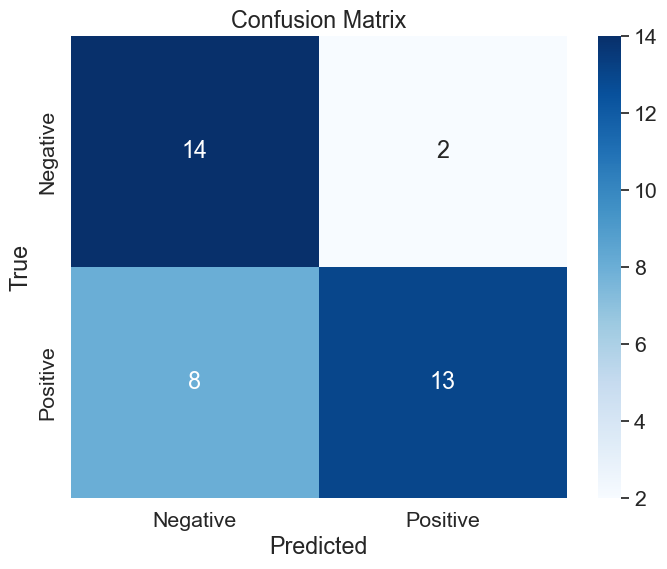

Wrong Buy_Act List:
USDTBRL 

FISBRL 

0:15:14.792509

Pred proft %: 1.0020888399055234
Gamble proft %: 1.0010883536844566
True proft %: 1.0072298881200201

Look Back: 2 / Total Loss: 2521596.9382189736 / Sold Portion: 0.8461538461538461 

['BTCBRL  ', 'LastPrice: 359000.0   ', 'MyGamble: 359365.15012', 'TruePrice: 361599.0   ', 'GambleProft: 1.001', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['USDTBRL ', 'LastPrice: 5.022      ', 'MyGamble: 5.03851    ', 'TruePrice: 5.019      ', 'GambleProft: 1.003', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2647.82462 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.01 ', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['XRPBRL  ', 'LastPrice: 3.124      ', 'MyGamble: 3.14067    ', 'TruePrice: 3.627      ', 'GambleProft: 1.005', 'TrueProft: 1.161', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8813     ', 'MyGamble: 0.89893    ', 'TruePrice: 0.9151     

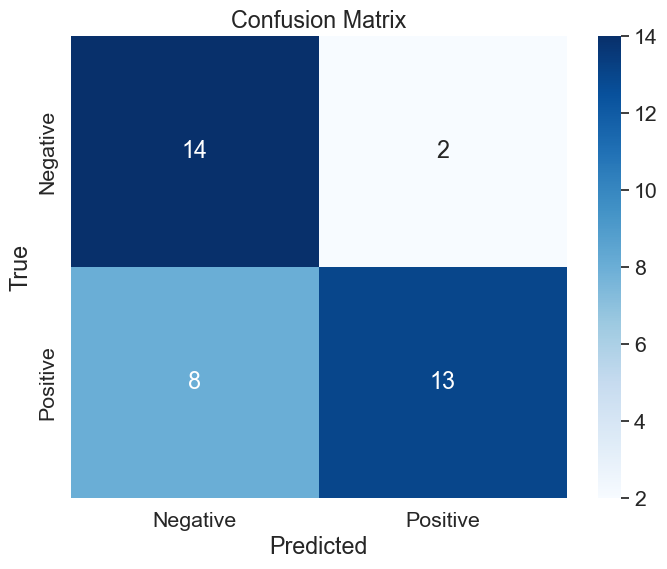

Wrong Buy_Act List:
USDTBRL 

BNBBRL 

0:14:24.281391

Pred proft %: 1.0020031673291212
Gamble proft %: 1.0009987939431026
True proft %: 1.0071877014098365

Look Back: 2 / Total Loss: 2721080.6108284383 / Sold Portion: 0.8571428571428571 

['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2645.7676  ', 'TruePrice: 2622.0     ', 'GambleProft: 1.009', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['ADABRL  ', 'LastPrice: 3.708      ', 'MyGamble: 3.72954    ', 'TruePrice: 3.884      ', 'GambleProft: 1.006', 'TrueProft: 1.047', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.8352    ', 'TruePrice: 55.35      ', 'GambleProft: 1.02 ', 'TrueProft: 1.03 ', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 745.5      ', 'MyGamble: 748.19253  ', 'TruePrice: 746.9      '

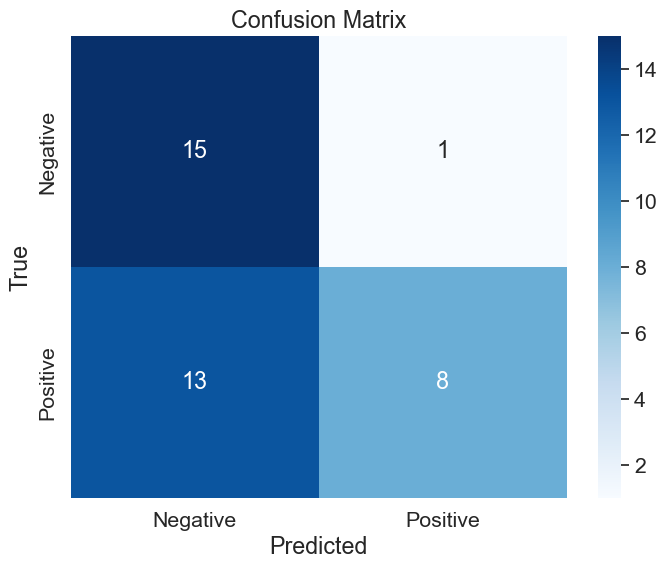

Wrong Buy_Act List:
BNBBRL 

0:14:25.804162

Pred proft %: 1.0036007574500618
Gamble proft %: 1.002657213601569
True proft %: 1.0089311021413307

Look Back: 2 / Total Loss: 9464453.620153131 / Sold Portion: 0.8333333333333334 

['ETHBRL  ', 'LastPrice: 20255.98   ', 'MyGamble: 20295.56498', 'TruePrice: 20402.59   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2622.0     ', 'MyGamble: 2641.88306 ', 'TruePrice: 2622.0     ', 'GambleProft: 1.008', 'TrueProft: 1.0  ', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97751    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 475.0      ', 'MyGamble: 477.02031  ', 'TruePrice: 521.3      ', 'GambleProft: 1.004', 'TrueProft: 1.097', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.76      ', 'MyGamble: 54.63166   ', 'TruePrice: 55.35      ', 'GamblePro

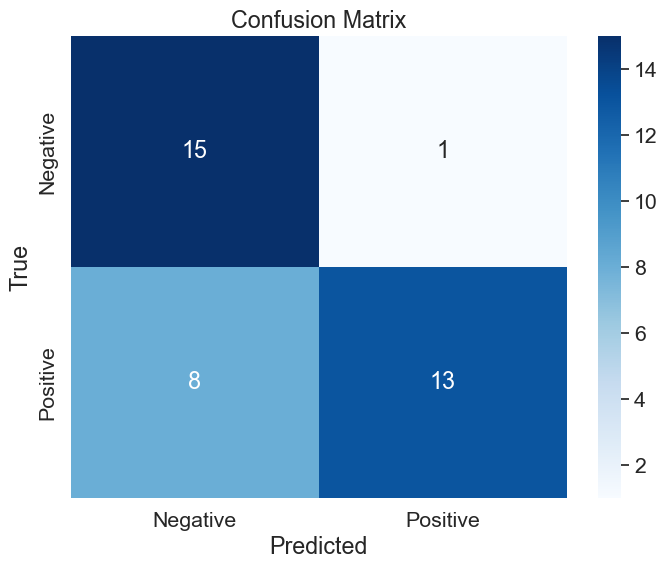

Wrong Buy_Act List:
BNBBRL 

0:14:32.982565


In [25]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 300, lb_list = [2], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [26]:
get_avg_gamble(verify_list)

BTTBRL / Gamble: 0.01473217500357117 / TruePrice: 0.01493 / SoldStatus: True / GambleProft: 1.0174154007991139
WINBRL / Gamble: 0.0009883656245012198 / TruePrice: 0.0010019 / SoldStatus: True / GambleProft: 1.0195642918312562
CAKEBRL / Gamble: 67.25480602931977 / TruePrice: 69.73 / SoldStatus: True / GambleProft: 1.0069592158903993
FTMBRL / Gamble: 1.8975882243855793 / TruePrice: 1.923 / SoldStatus: True / GambleProft: 1.014210702504318
XRPBRL / Gamble: 3.1540938645601275 / TruePrice: 3.627 / SoldStatus: True / GambleProft: 1.009633119257403
AXSBRL / Gamble: 38.46562153244018 / TruePrice: 38.75 / SoldStatus: True / GambleProft: 1.0095963656808447
GMTBRL / Gamble: 1.3422453343812624 / TruePrice: 1.337 / SoldStatus: False / GambleProft: 1.0191688188164483


{'BTTBRL': 0.01473217500357117,
 'WINBRL': 0.0009883656245012198,
 'CAKEBRL': 67.25480602931977,
 'FTMBRL': 1.8975882243855793,
 'XRPBRL': 3.1540938645601275,
 'AXSBRL': 38.46562153244018,
 'GMTBRL': 1.3422453343812624}

In [ ]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 200, lb_list = [3], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [ ]:
get_avg_gamble(verify_list)

In [ ]:
verify_list = []
for i in range(10):
    d = dt.datetime.now()
    verify_buy = pred_eval(model_3, epochs = 300, lb_list = [3], ticker_list = symbols, print_info = False)
    verify_list.append(verify_buy)
    d2 = dt.datetime.now()
    print(d2-d)

In [ ]:
get_avg_gamble(verify_list)

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
